# Model

\begin{align}
  \tau & \sim \mathrm{Exponential}(1 / 0.03) \\
  y_m & \sim \mathrm{Exponential}(\tau) \quad & \text{for} \quad m = 1, \dots, M \\
  \phi  & \sim \mathcal{N}^{ + }(0, 5) \\
  \kappa & \sim \mathcal{N}^{ + }(0, 0.5) \\
  \mu_m & \sim \mathcal{N}^{ + }(3.28, \kappa) \quad & \text{for} \quad m = 1, \dots, M \\
  \tilde{\alpha}_k &\sim \mathrm{Gamma}(0.1667, 1) \quad & \text{for} \quad k = 1, \dots, K \\
  \alpha_k &= \tilde{\alpha}_k - \frac{\log(1.05)}{6} \quad & \text{for} \quad  k = 1, \dots, K \\
  \varepsilon_m^{\text{ifr}} &\sim \mathcal{N}(1, 0.1)^{ + } \quad & \text{for} \quad m = 1, \dots, M \\
  \mathrm{ifr}_m^{ * } &\sim \mathrm{ifr}_m \cdot \varepsilon_m^{\text{ifr}} \quad & \text{for} \quad m = 1, \dots, M \\
  R_{t, m} &= \mu_m \exp(- \sum_{k=1}^{K} \alpha_k x_k) \quad & \text{for} \quad m = 1, \dots, M, \ t = 1, \dots, T  \\
  c_{t, m} &= R_{t, m} \bigg(1 - \frac{c_{t - 1, m}}{p_m} \bigg) \sum_{\tau = 1}^{t - 1} c_{\tau, m} s_{t - \tau} \quad & \text{for} \quad m = 1, \dots, M, \ t = 1, \dots, T \\
  d_{t, m} &= \mathrm{ifr}_m^{ * } \sum_{\tau=1}^{t - 1} c_{\tau, m} \pi_{t - \tau} \quad & \text{for} \quad m = 1, \dots, M, \ t = 1, \dots, T \\
  D_{t, m} &\sim \mathrm{NegativeBinomial}(d_{t, m}, \phi) \quad & \text{for} \quad m = 1, \dots, M, \ t = 1, \dots, T 
\end{align}

where
- $\mu_m$ represents the $R_0$ value for country $m$ (i.e. $R_t$ without any interventions)
- $\mathrm{ifr}_m$ denotes the /infection-fatality ratio/ for country $m$
- $\varepsilon_m^{\text{ifr}}$ denotes the noise for the multiplicative noise for the $\mathrm{ifr}_m^{ * }$
- $R_{t, m}$ denotes the /R-value/ at time $t$ for country $m$
- $p_{m}$ denotes the total/initial population for country $m$
- $\pi$ denotes the /time from infection to death/ and is assumed to be a sum of two independent random times: the /incubation period/ (infection-to-onset) and time between onset of symptoms and death (onset-to-death):
  \begin{equation*}
  \pi \sim \mathrm{Gamma}(5.1, 0.86) + \mathrm{Gamma}(18.8, 0.45)
  \end{equation*}
  where in this case the $\mathrm{Gamma}$ is parameterized by its mean and coefficient of variation.
- $\pi_t$ then denotes a discretized version of the PDF of $\pi$
- $c_{t, m}$ denotes the /expected daily cases/ at time $t$ for country $m$
- $d_{t, m}$ denotes the /expected daily deaths/ at time $t$ for country $m$
- $D_{t, m}$ denotes the /daily deaths/ at time $t$ for country $m$


# Code

In [1]:
using DrWatson

In [2]:
quickactivate(@__DIR__)

Activating environment at `~/Projects/mine/Covid19/Project.toml`


In [3]:
projectdir()

"/var/home/tef30/Projects/mine/Covid19"

In [4]:
# ENV["PYTHON"] = "$(ENV['HOME'])/.local/bin/python"

# using Pkg
# Pkg.build("PyCall")

In [5]:
using Covid19

In [6]:
using Turing
using Base.Threads
nthreads()

4

In [7]:
using Random
Random.seed!(1);

In [8]:
using Bijectors

In [9]:
begin
    dist = product_distribution(fill(truncated(Normal(3.28, 10), 0, Inf), 14))
    b = bijector(dist)
    x = rand(dist)

    # stupid check to make sure that we have the correct versions of Bijectors.jl used WITHIN Turing.jl
    @assert (invlink(dist, b(x)) ≈ Turing.invlink(dist, b(x))) && (Turing.invlink(dist, b(x)) ≈ x)
end

# Load data

In [10]:
using RData

In [11]:
import DrWatson: datadir

datadir() = projectdir("data", "imperial-report13")
datadir(s...) = projectdir("data", "imperial-report13", s...)

datadir (generic function with 2 methods)

In [12]:
rdata = load(datadir("processed.rds"));

┌ Warning: Conversion of RData.RDummy{0xfe} to Julia is not implemented
└ @ RData /var/home/tef30/.julia/packages/RData/7cjT6/src/convert.jl:142
┌ Warning: Unsupported AltRep SEXP
└ @ RData /var/home/tef30/.julia/packages/RData/7cjT6/src/convert.jl:205


In [13]:
# Convert some misparsed fields
# rdata["covariate4"] = Matrix(rdata["covariate4"]);

rdata["N2"] = Int(rdata["N2"]);
rdata["N0"] = Int(rdata["N0"]);

rdata["EpidemicStart"] = Int.(rdata["EpidemicStart"]);

rdata["cases"] = Int.(rdata["cases"]);
rdata["deaths"] = Int.(rdata["deaths"]);

# Stan will fail if these are `nothing` so we make them empty arrays
rdata["x"] = []
rdata["features"] = []

0-element Array{Any,1}

## Make data a bit more convenient to work with

In [14]:
countries = (
  "Denmark",
  "Italy",
  "Germany",
  "Spain",
  "United_Kingdom",
  "France",
  "Norway",
  "Belgium",
  "Austria", 
  "Sweden",
  "Switzerland",
  "Greece",
  "Portugal",
  "Netherlands"
)
num_countries = length(countries)

# TODO: not sure if either of the below is the correct ordering of the names!
# names_covariates = (
#     "Schools + Universities",
#     "Self-isolating if ill",
#     "Public events",
#     "Lockdown",
#     "Social distancing encouraged"
# )
names_covariates = ("schools_universities", "self_isolating_if_ill", "public_events", "any", "lockdown", "social_distancing_encouraged")

function rename!(d, names::Pair...)
    # check that keys are not yet present before updating `d`
    for k_new in values.(names)
        @assert k_new ∉ keys(d) "$(k_new) already in dictionary"
    end
    
    for (k_old, k_new) in names
        d[k_new] = pop!(d, k_old)
    end
    return d
end


rename! (generic function with 1 method)

In [15]:
# `rdata` is a `DictOfVector` so we convert to a simple `Dict` for simplicity
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

# Rename some columns
rename!(
    d,
    "f" => "π", "SI" => "serial_intervals", "pop" => "population",
    "M" => "num_countries", "N0" => "num_impute", "N" => "num_obs_countries",
    "N2" => "num_total_days", "EpidemicStart" => "epidemic_start",
    "X" => "covariates", "P" => "num_covariates"
)

# Add some type-information to arrays and replace `-1` with `missing` (as `-1` is supposed to represent, well, missing data)
d["deaths"] = Int.(d["deaths"])
# d["deaths"] = replace(d["deaths"], -1 => missing)
d["deaths"] = collect(eachcol(d["deaths"])) # convert into Array of arrays instead of matrix

d["cases"] = Int.(d["cases"])
# d["cases"] = replace(d["cases"], -1 => missing)
d["cases"] = collect(eachcol(d["cases"])) # convert into Array of arrays instead of matrix

d["num_covariates"] = Int(d["num_covariates"])
d["num_countries"] = Int(d["num_countries"])
d["num_total_days"] = Int(d["num_total_days"])
d["num_impute"] = Int(d["num_impute"])
d["num_obs_countries"] = Int.(d["num_obs_countries"])
d["epidemic_start"] = Int.(d["epidemic_start"])
d["population"] = Int.(d["population"])

d["π"] = collect(eachcol(d["π"])) # convert into Array of arrays instead of matrix

# Convert 3D array into Array{Matrix}
covariates = [rdata["X"][m, :, :] for m = 1:num_countries]

data = (; (k => d[String(k)] for k in [:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :epidemic_start, :population, :serial_intervals])...)
data = merge(data, (covariates = covariates, ));

In [16]:
data.num_countries

14

# Trying out the model

In [17]:
model_def = ImperialReport13.model_v2_vectorized_multithreaded

DynamicPPL.ModelGen{Covid19.ImperialReport13.var"###generator#635",(:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :covariates, :epidemic_start, :population, :serial_intervals, :predict, :TV),(:predict, :TV),Tuple{Bool,Type{Array{Float64,1}}}}(Covid19.ImperialReport13.##generator#635, NamedTuple{(:predict, :TV),Tuple{Bool,Type{Array{Float64,1}}}}((false, Array{Float64,1})))

In [18]:
m = model_def(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    data.covariates,
    data.epidemic_start,
    data.population,
    data.serial_intervals
);

In [19]:
parameters = (
    warmup = 100,
    steps = 1000,
    model = "imperial-report13-v2-vectorized-non-predict-$(nthreads())-threads"
)

(warmup = 100, steps = 1000, model = "imperial-report13-v2-vectorized-non-predict-4-threads")

In [20]:
# chain = read(savename("chains", parameters, "jls"), Chains);

In [21]:
chain = sample(m, NUTS(parameters.warmup, 0.95; max_depth=10), parameters.steps + parameters.warmup);
# write(savename("chains", parameters, "jls"), chain)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /var/home/tef30/.julia/packages/Turing/udhWN/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 2:07:50


In [112]:
# write(savename("chains", parameters, "jls"), chain)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648


In [21]:
m = model_def(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    data.covariates,
    data.epidemic_start,
    data.population,
    data.serial_intervals,
    true # <= use full model
);

In [22]:
chain

Object of type Chains, with data of type 1000×63×1 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ₀[1], μ₀[2], μ₀[3], μ₀[4], μ₀[5], μ₀[6], μ₀[7], μ₀[8], μ₀[9], μ₀[10], μ₀[11], μ₀[12], μ₀[13], μ₀[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters      mean      std  naive_se    mcse        ess   r_hat
  ─────────────  

In [23]:
mean(chain)

Mean
     parameters      mean
  ─────────────  ────────
   ifr_noise[1]    0.9937
   ifr_noise[2]    0.9967
   ifr_noise[3]    0.9898
   ifr_noise[4]    1.0037
   ifr_noise[5]    0.9983
   ifr_noise[6]    0.9938
   ifr_noise[7]    0.9947
   ifr_noise[8]    0.9911
   ifr_noise[9]    1.0028
  ifr_noise[10]    1.0111
  ifr_noise[11]    0.9970
  ifr_noise[12]    0.9998
  ifr_noise[13]    0.9973
  ifr_noise[14]    1.0110
           y[1]   44.6853
           y[2]   36.2666
           y[3]   18.4317
           y[4]   93.3267
           y[5]   43.6692
           y[6]    8.0335
           y[7]   28.1514
           y[8]   12.3368
           y[9]   70.5586
          y[10]  143.9500
          y[11]   25.5816
          y[12]   85.2861
          y[13]   52.7903
          y[14]   83.3656
      α_hier[1]    0.0288
      α_hier[2]    0.0339
      α_hier[3]    0.4990
      α_hier[4]    0.0149
      α_hier[5]    1.1200
      α_hier[6]    0.0629
              κ    1.1647
          μ₀[1]    4.0154
       

In [26]:
histogram(vec(get(chain, :lp).lp))

UndefVarError: UndefVarError: histogram not defined

## Prior

In [24]:
chain_prior = sample(m, Turing.Inference.PriorSampler(), 10_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


In [25]:
chain_prior

Object of type Chains, with data of type 10000×52×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
internals         = lp
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ₀[1], μ₀[2], μ₀[3], μ₀[4], μ₀[5], μ₀[6], μ₀[7], μ₀[8], μ₀[9], μ₀[10], μ₀[11], μ₀[12], μ₀[13], μ₀[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters     mean      std  naive_se    mcse         ess   r_hat
  ─────────────  ───────  ───────  ────────  ──────  ──────────  ──────
   ifr_noise[1]   0.9985   0.1003    0.0010  0.0010  10384.2841  0.9999
   ifr_noise[2]   0.9985   0.1003    0.0010  0.0010

# Predictions 

In [27]:
"""
    generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)

Executes `m` for each of the samples in `c` and returns an array of the values returned by the `m` for each sample.

## Examples
Often you might have additional quantities computed inside the model that you want to inspect, e.g.
```julia
@model demo(x) = begin
    # sample and observe
    θ ~ Prior()
    x ~ Likelihood()

    return interesting_quantity(θ, x)
end

m = demo(data)
chain = sample(m, alg, n)

# To inspect the `interesting_quantity(θ, x)` where `θ` is replaced by samples from the posterior/`chain`:
generated_quantities(m, chain)
```
"""
function generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)
    varinfo = Turing.DynamicPPL.VarInfo(m)

    map(1:length(c)) do i
        Turing.DynamicPPL._setval!(varinfo, c[i])
        m(varinfo)
    end
end


generated_quantities

# Visualization

In [28]:
using Plots, StatsPlots
pyplot()

Plots.PyPlotBackend()

In [29]:
function plot_confidence!(p::Plots.Plot, data; label="", kwargs...)
    intervals = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    qs = [quantile(v, intervals) for v in eachrow(data)]
    llq, lq, mq, uq, uuq = (eachrow(hcat(qs...))..., )
    plot!(mq, ribbon=(mq - llq, uuq - mq), linewidth=0, label="$label (95% quantiles)", kwargs...)
    plot!(mq, ribbon=(mq - lq, uq - mq), linewidth=0, label="$label (50% quantiles)", kwargs...)

    return p
end

plot_confidence(data; kwargs...) = plot_confidence!(plot(), data; kwargs...)

plot_confidence (generic function with 1 method)

In [30]:
function country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
    p1 = bar(replace(data.deaths[country_idx], missing => 0.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")
    bar!(replace(data.deaths[country_idx], missing => 0.), label="$(countries[country_idx]) (observed)", alpha=0.5)

    p3 = plot_confidence(Rₜ_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            if (c_name != "any")
                # Don't add the "any intervention" stuff
                vline!([c_time - 1], label=c_name)
            end
        end
    end
    title!("Rₜ")
    ylims!(0, maximum(Rₜ_country) + 0.1)

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")
    bar!(replace(data.cases[country_idx], missing => 0.), label="$(countries[country_idx]) (observed)", alpha=0.5)

    vals = cumsum(e_deaths_country; dims = 1)
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum([x for x in data.deaths[country_idx] if x > -1]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum([x for x in data.cases[country_idx] if x > -1]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_plot (generic function with 1 method)

In [31]:
# Compute the "generated quantities" for the PRIOR
res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

In [32]:
# Compute the "generated quantities" from the POSTERIOR
res = generated_quantities(m, chain)
prediction_chain = [x[1] for x in res];
expected_deaths_chain = [x[2] for x in res];
Rₜ_chain = [x[3] for x in res];

In [33]:
# HACK: eeehm this could be nicer:)
function country_prior_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    Rₜ_country = hcat([Rₜ_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    predictions_country = hcat([prediction_prior[t][country_idx] for t = 1:length(chain_prior)]...)

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_prior_prediction_plot (generic function with 1 method)

In [34]:
function country_posterior_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_chain[t][country_idx] for t = 1:length(chain)]...)
    Rₜ_country = hcat([Rₜ_chain[t][country_idx] for t = 1:length(chain)]...)
    predictions_country = hcat([prediction_chain[t][country_idx] for t = 1:length(chain)]...)

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_posterior_prediction_plot (generic function with 1 method)

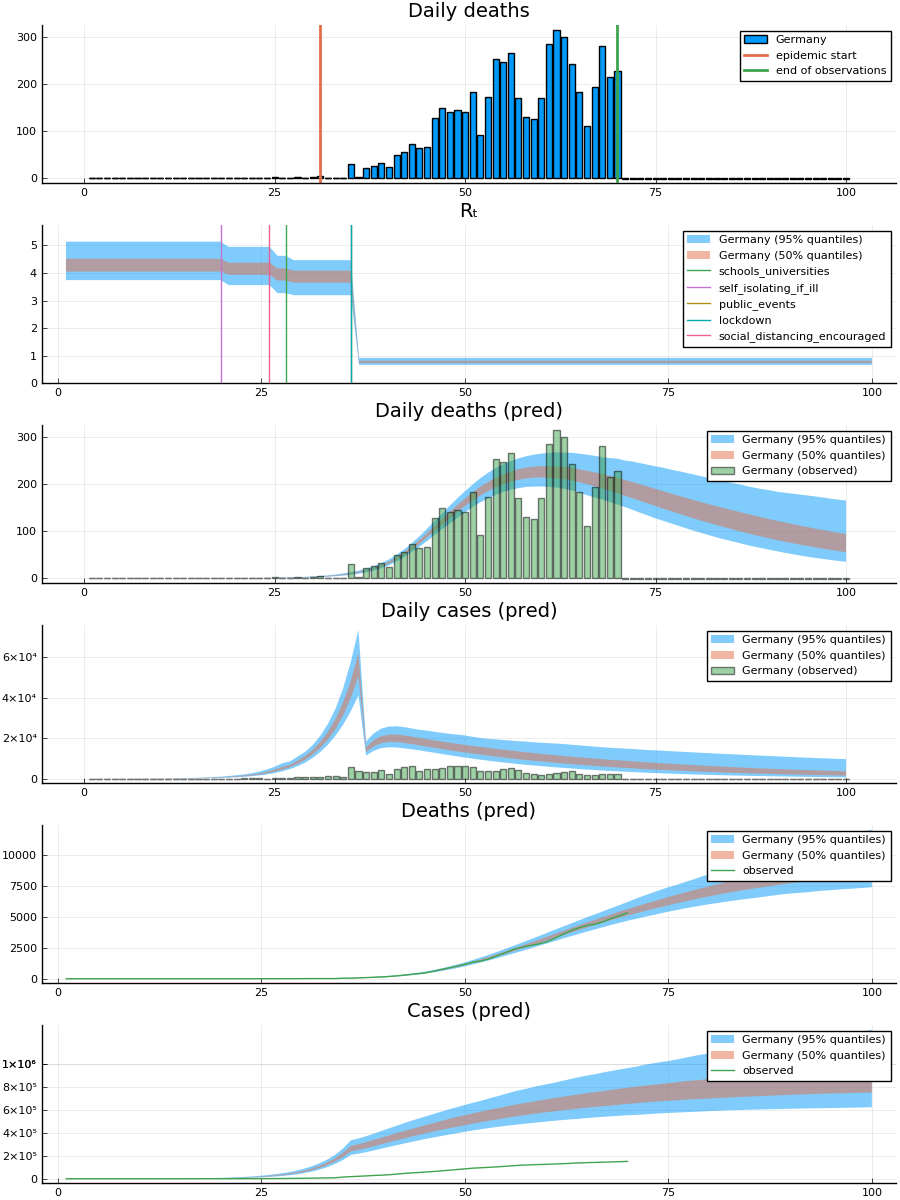

In [35]:
country_posterior_prediction_plot(3)

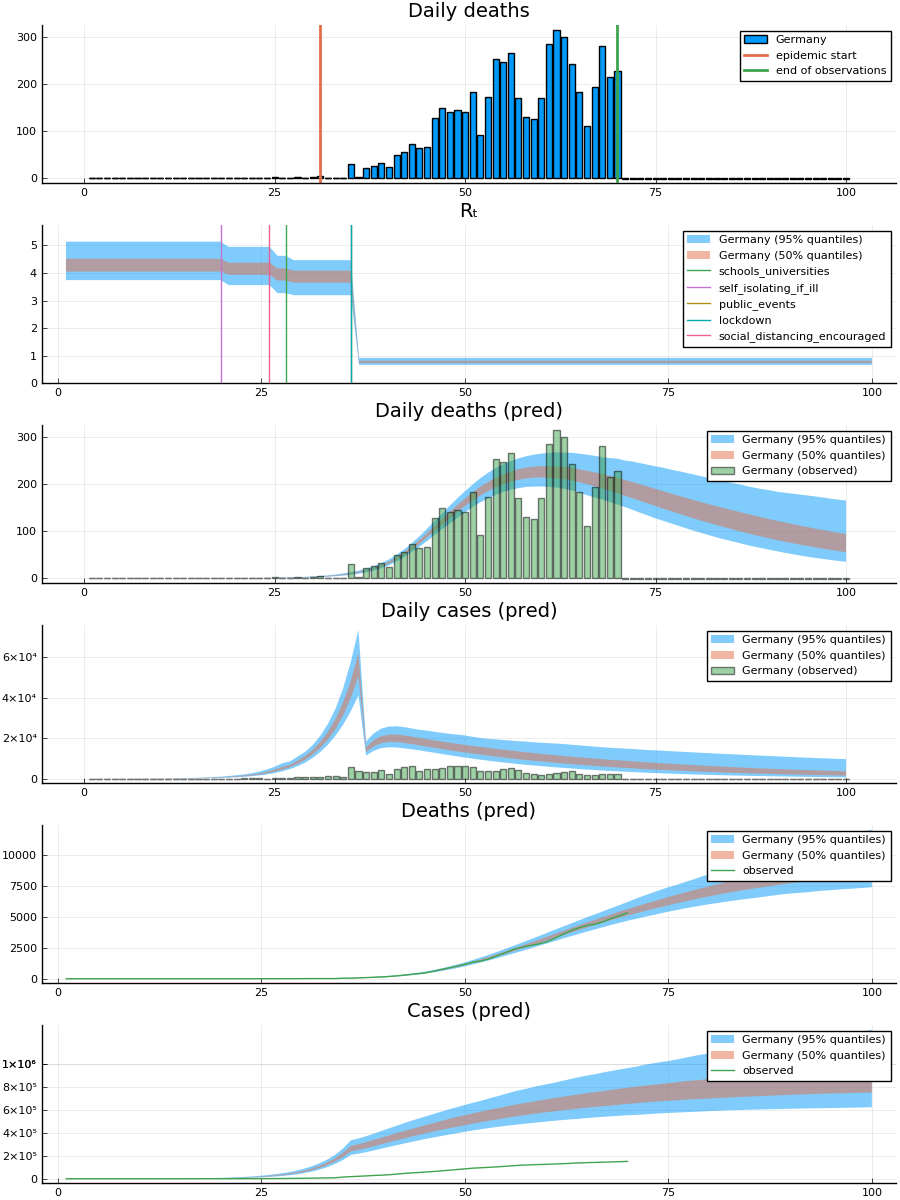

In [36]:
country_posterior_prediction_plot(3)

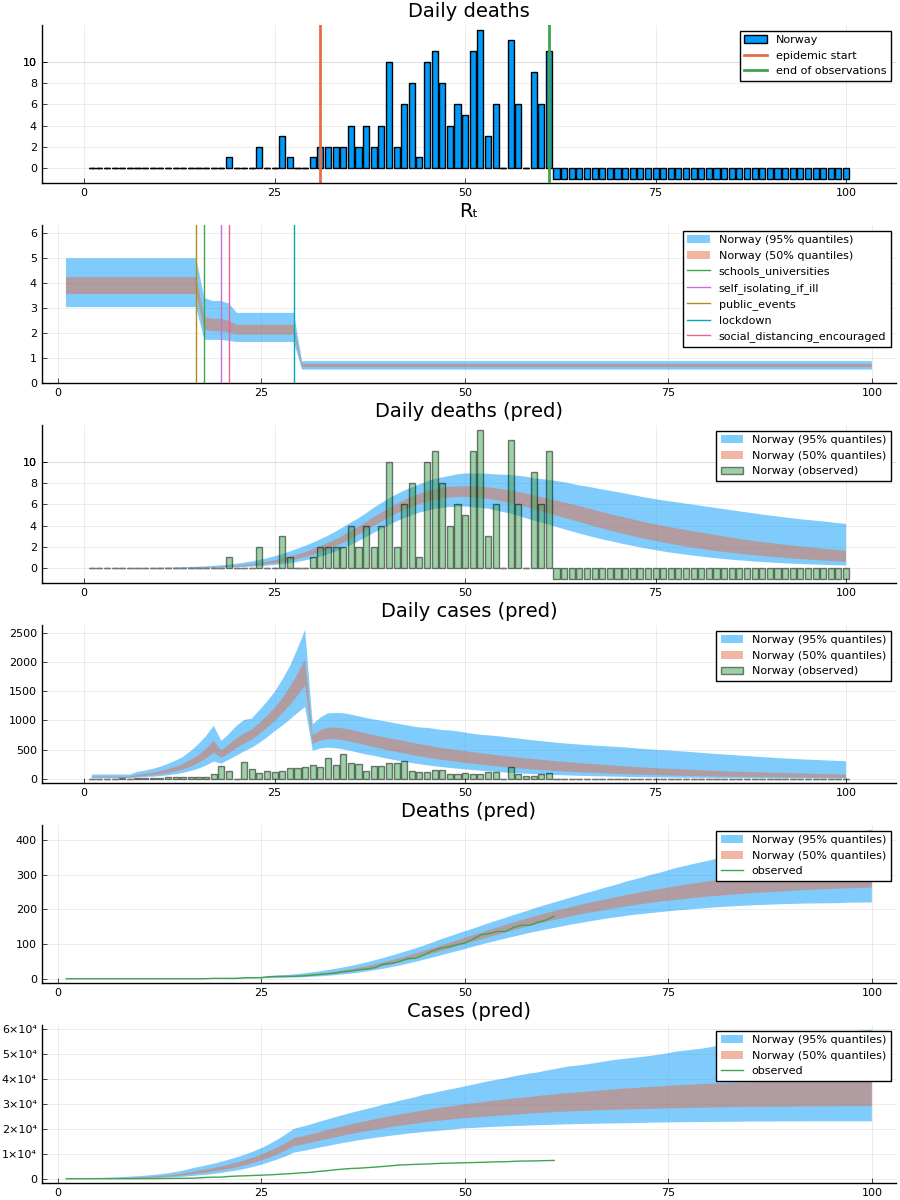

In [37]:
country_posterior_prediction_plot(7)

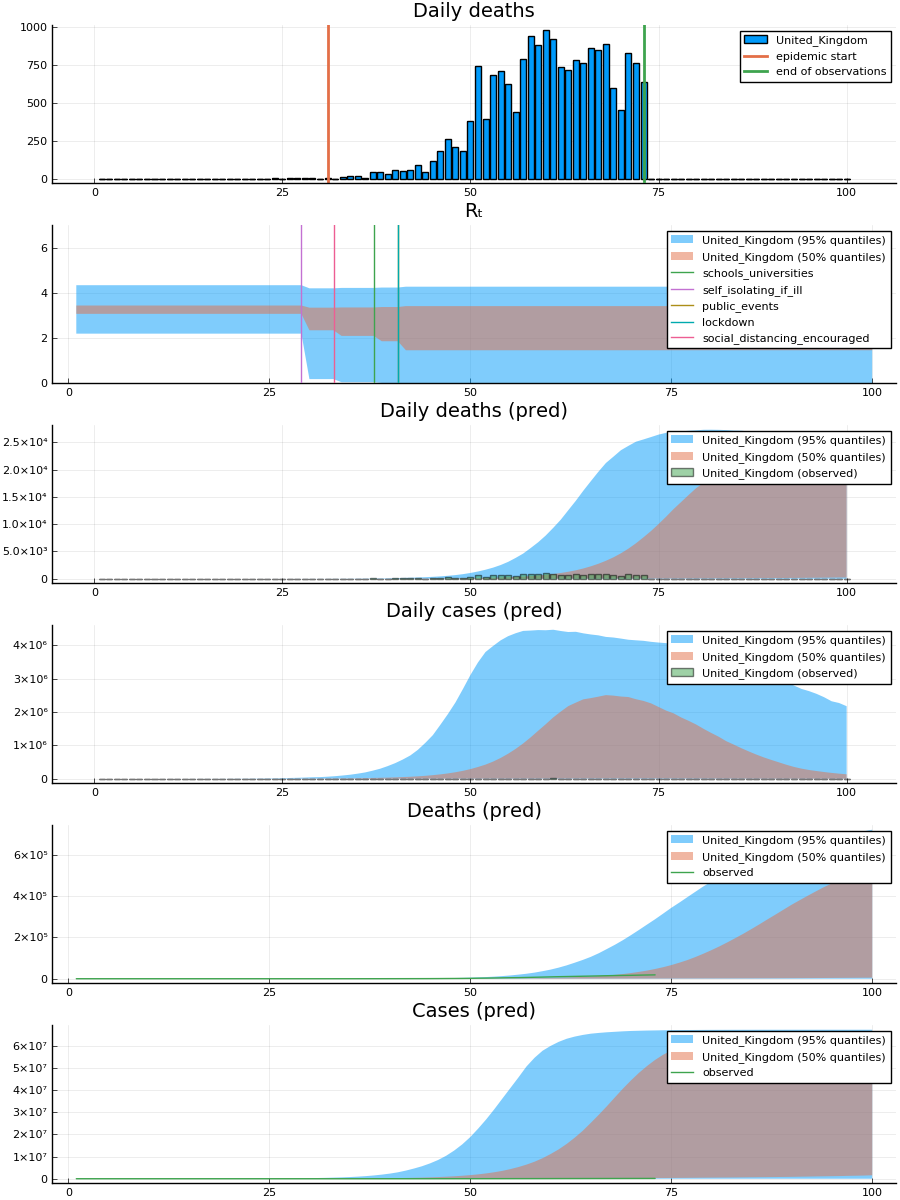

In [38]:
country_prior_prediction_plot(5)

# Counter-factual model

In [39]:
names_covariates

("schools_universities", "self_isolating_if_ill", "public_events", "any", "lockdown", "social_distancing_encouraged")

In [40]:
"""
    zero_covariates(xs::AbstractMatrix{<:Real}; exclude=[], include=[])

Allows you to zero out covariates if the name of the covariate is in `exclude` or NOT zero out those in `include`.
Note that only `exclude` xor `include` can be non-empty.

Useful when instantiating counter-factual models, as it allows one to remove/include a subset of the covariates.
"""
function zero_covariates(xs::AbstractMatrix{<:Real}; exclude=[], include=[])
    @assert (isempty(exclude) || isempty(include)) "only `exclude` or `include` can be non-empty"
    
    if isempty(include)
        return hcat([
            (names_covariates[i] ∈ exclude ? zeros(eltype(c), length(c)) : c) 
            for (i, c) in enumerate(eachcol(xs))
        ]...)
    else
        return hcat([
        (names_covariates[i] ∈ include ? c : zeros(eltype(c), length(c))) 
        for (i, c) in enumerate(eachcol(xs))
        ]...)
    end
end

zero_covariates

In [67]:
# What happens if we never close schools?
m_counterfactual = model_def(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    [zero_covariates(c; exclude = ["schools_universities"]) for c in data.covariates], # <= remove covariates
    data.epidemic_start,
    data.population,
    data.serial_intervals,
    true # <= use full model
);

In [68]:
# Compute the "generated quantities" for the PRIOR
res = generated_quantities(m_counterfactual, chain)
prediction_counterfactual = [x[1] for x in res];
expected_deaths_counterfactual = [x[2] for x in res];
Rₜ_counterfactual = [x[3] for x in res];

In [69]:
function country_counterfactual_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_counterfactual[t][country_idx] for t = 1:length(chain)]...)
    Rₜ_country = hcat([Rₜ_counterfactual[t][country_idx] for t = 1:length(chain)]...)
    predictions_country = hcat([prediction_counterfactual[t][country_idx] for t = 1:length(chain)]...)

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_counterfactual_prediction_plot (generic function with 1 method)

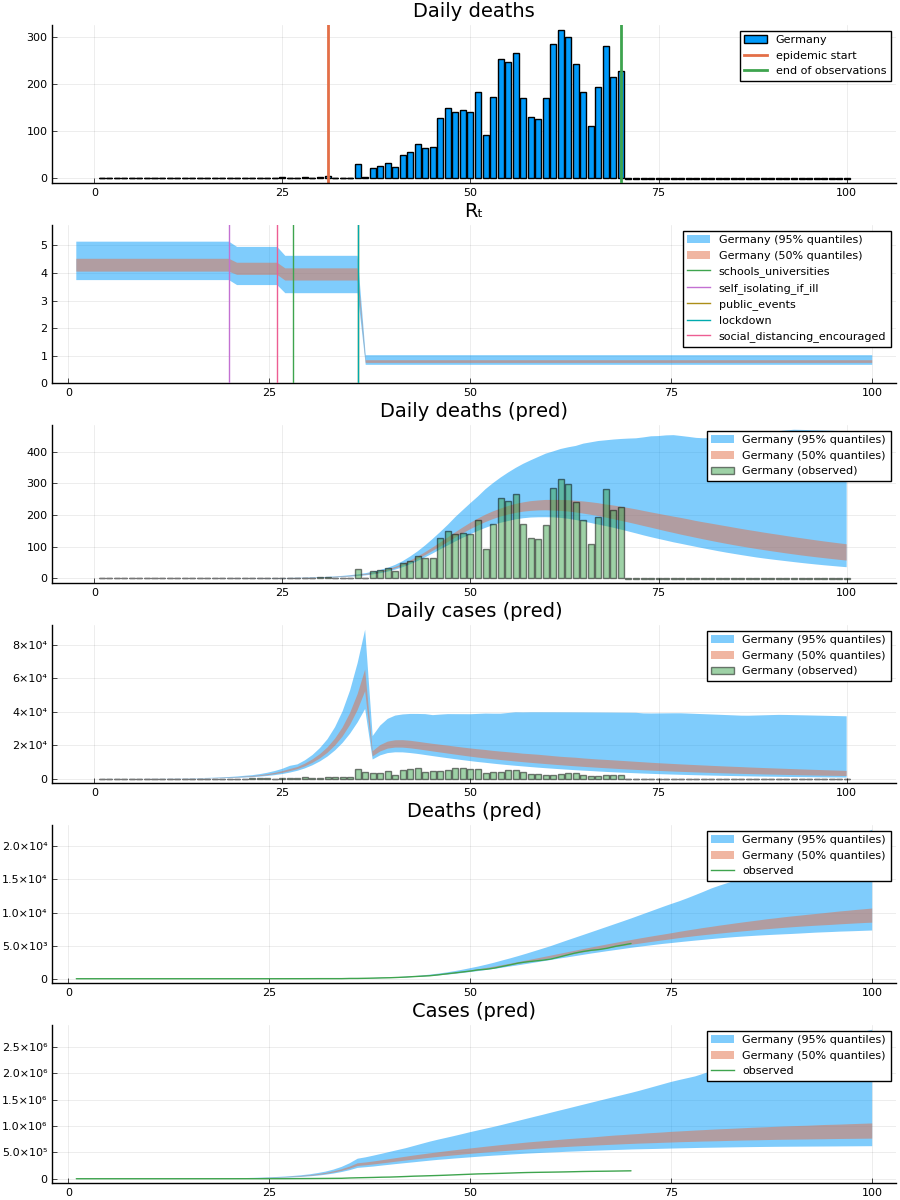

In [71]:
country_counterfactual_prediction_plot(3)

# Comparing with Stan

In [45]:
using PyCall

In [46]:
using PyCall: pyimport
pystan = pyimport("pystan")

PyObject <module 'pystan' from '/var/home/tef30/.local/lib/python3.5/site-packages/pystan/__init__.py'>

In [47]:
using LibGit2

imperialdir() = projectdir("external", "covid19model")
imperialdir(args...) = projectdir("external", "covid19model", args...)

if !ispath(imperialdir())
    mkpath(projectdir("external"))
    LibGit2.clone("https://github.com/ImperialCollegeLondon/covid19model.git", imperialdir())
end

In [48]:
model_str = raw"""
data {
  int <lower=1> M; // number of countries
  int <lower=1> P; // number of covariates
  int <lower=1> N0; // number of days for which to impute infections
  int<lower=1> N[M]; // days of observed data for country m. each entry must be <= N2
  int<lower=1> N2; // days of observed data + # of days to forecast
  int cases[N2,M]; // reported cases
  int deaths[N2, M]; // reported deaths -- the rows with i > N contain -1 and should be ignored
  matrix[N2, M] f; // h * s
  matrix[N2, P] X[M]; // features matrix
  int EpidemicStart[M];
  real pop[M];
  real SI[N2]; // fixed pre-calculated SI using emprical data from Neil
}

transformed data {
  vector[N2] SI_rev; // SI in reverse order
  vector[N2] f_rev[M]; // f in reversed order
  
  for(i in 1:N2)
    SI_rev[i] = SI[N2-i+1];
    
  for(m in 1:M){
    for(i in 1:N2) {
     f_rev[m, i] = f[N2-i+1,m];
    }
  }
}


parameters {
  real<lower=0> mu[M]; // intercept for Rt
  real<lower=0> alpha_hier[P]; // sudo parameter for the hier term for alpha
  real<lower=0> gamma;
  vector[M] lockdown;
  real<lower=0> kappa;
  real<lower=0> y[M];
  real<lower=0> phi;
  real<lower=0> tau;
  real <lower=0> ifr_noise[M];
}

transformed parameters {
    vector[P] alpha;
    matrix[N2, M] prediction = rep_matrix(0,N2,M);
    matrix[N2, M] E_deaths  = rep_matrix(0,N2,M);
    matrix[N2, M] Rt = rep_matrix(0,N2,M);
    matrix[N2, M] Rt_adj = Rt;
    
    {
      matrix[N2,M] cumm_sum = rep_matrix(0,N2,M);
      for(i in 1:P){
        alpha[i] = alpha_hier[i] - ( log(1.05) / 6.0 );
      }
      for (m in 1:M){
        prediction[1:N0,m] = rep_vector(y[m],N0); // learn the number of cases in the first N0 days
        cumm_sum[2:N0,m] = cumulative_sum(prediction[2:N0,m]);
        
        Rt[,m] = mu[m] * exp(-X[m] * alpha - X[m][,5] * lockdown[m]);
        Rt_adj[1:N0,m] = Rt[1:N0,m];
        for (i in (N0+1):N2) {
          real convolution = dot_product(sub_col(prediction, 1, m, i-1), tail(SI_rev, i-1));
          cumm_sum[i,m] = cumm_sum[i-1,m] + prediction[i-1,m];
          Rt_adj[i,m] = ((pop[m]-cumm_sum[i,m]) / pop[m]) * Rt[i,m];
          prediction[i, m] = Rt_adj[i,m] * convolution;
        }
        E_deaths[1, m]= 1e-15 * prediction[1,m];
        for (i in 2:N2){
          E_deaths[i,m] = ifr_noise[m] * dot_product(sub_col(prediction, 1, m, i-1), tail(f_rev[m], i-1));
        }
      }
    }
}
model {
  tau ~ exponential(0.03);
  for (m in 1:M){
      y[m] ~ exponential(1/tau);
  }
  gamma ~ normal(0,.2);
  lockdown ~ normal(0,gamma);
  phi ~ normal(0,5);
  kappa ~ normal(0,0.5);
  mu ~ normal(3.28, kappa); // citation: https://academic.oup.com/jtm/article/27/2/taaa021/5735319
  alpha_hier ~ gamma(.1667,1);
  ifr_noise ~ normal(1,0.1);
  for(m in 1:M){
    deaths[EpidemicStart[m]:N[m], m] ~ neg_binomial_2(E_deaths[EpidemicStart[m]:N[m], m], phi);
   }
}

generated quantities {
    matrix[N2, M] prediction0 = rep_matrix(0,N2,M);
    matrix[N2, M] E_deaths0  = rep_matrix(0,N2,M);
    
    {
      matrix[N2,M] cumm_sum0 = rep_matrix(0,N2,M);
      for (m in 1:M){
         for (i in 2:N0){
          cumm_sum0[i,m] = cumm_sum0[i-1,m] + y[m]; 
        }
        prediction0[1:N0,m] = rep_vector(y[m],N0); 
        for (i in (N0+1):N2) {
          real convolution0 = dot_product(sub_col(prediction0, 1, m, i-1), tail(SI_rev, i-1));
          cumm_sum0[i,m] = cumm_sum0[i-1,m] + prediction0[i-1,m];
          prediction0[i, m] = ((pop[m]-cumm_sum0[i,m]) / pop[m]) * mu[m] * convolution0;
        }
        E_deaths0[1, m]= 1e-15 * prediction0[1,m];
        for (i in 2:N2){
          E_deaths0[i,m] = ifr_noise[m] * dot_product(sub_col(prediction0, 1, m, i-1), tail(f_rev[m], i-1));
        }
      }
    }
}
""";

In [49]:
model_str_fast = raw"""
functions {
  // calculates for a given country the model outputs as column
  // vectors. These are saved as an array with the outputs of (1)
  // E_deaths, (2) prediction, (3) Rt, (4) R_adj
  vector[] country_model(real mu_local,
                         vector alpha,
                         real y_local,
                         real ifr_noise_local,
                         int N0,
                         int N2,
                         matrix X_local,
                         vector SI_rev,
                         real pop_local,
                         vector f_rev_local
                         ) {
    vector[N2] prediction = rep_vector(0.0, N2);
    vector[N2] E_deaths = rep_vector(0.0, N2);
    vector[N2] Rt = rep_vector(0.0, N2);
    vector[N2] Rt_adj = rep_vector(0.0, N2);
    vector[N2] cumm_sum = rep_vector(0.0, N2);
    
    // learn the number of cases in the first N0 days
    prediction[1:N0] = rep_vector(y_local, N0); 
    cumm_sum[2:N0] = cumulative_sum(prediction[2:N0]);
    
    Rt = mu_local * exp( - X_local * alpha );
    Rt_adj[1:N0] = Rt[1:N0];
    
    for (i in (N0+1):N2) {
      real convolution = dot_product(head(prediction, i-1), tail(SI_rev, i-1));
      
      cumm_sum[i] = cumm_sum[i-1] + prediction[i-1];
      Rt_adj[i] = ((pop_local-cumm_sum[i]) / pop_local) * Rt[i];
      prediction[i] = Rt_adj[i] * convolution;
    }

    E_deaths[1]= 1e-15 * prediction[1];
    for (i in 2:N2) {
      E_deaths[i] = ifr_noise_local * dot_product(head(prediction, i-1), tail(f_rev_local, i-1));
    }

    return({ E_deaths, prediction, Rt, Rt_adj });
}
  
  // this is the partial sum function which calculates for
  // a subset of countries the log-lik contribution
  // so it computes for the countries m= start...end the
  // log lik
  real country_lpdf(real[] mu_slice,
                    int start, int end,
                    vector alpha,
                    real[] y,
                    real phi,
                    real[] ifr_noise,
                    int[] N,
                    int N0,
                    int N2,
                    matrix[] X,
                    vector SI_rev,
                    real[] pop,
                    vector[] f_rev,
                    int[,] deaths,
                    int[] EpidemicStart
                    ) {
    // log-lik of this subset
    real log_lik = 0.0;
    
    for (m in start:end) {
      int m_slice = m - start + 1;
      vector[N2] E_deaths = country_model(
          mu_slice[m_slice],
          alpha,
          y[m],
          ifr_noise[m],
          N0,
          N2,
          X[m],
          SI_rev,
          pop[m],
          f_rev[m])[1];
      
      log_lik += neg_binomial_2_lpmf(deaths[EpidemicStart[m]:N[m], m] |
                                     E_deaths[EpidemicStart[m]:N[m]], phi );
    }

    return(log_lik);
  }
}

data {
  int <lower=1> M; // number of countries
  int <lower=1> P; // number of covariates
  int <lower=1> N0; // number of days for which to impute infections
  int<lower=1> N[M]; // days of observed data for country m. each entry must be <= N2
  int<lower=1> N2; // days of observed data + # of days to forecast
  int cases[N2,M]; // reported cases
  int deaths[N2, M]; // reported deaths -- the rows with i > N contain -1 and should be ignored
  matrix[N2, M] f; // h * s
  matrix[N2, P] X[M];
  int EpidemicStart[M];
  real pop[M];
  real SI[N2]; // fixed pre-calculated SI using emprical data from Neil
}

transformed data {
  vector[N2] SI_rev; // SI in reverse order
  vector[N2] f_rev[M]; // f in reversed order
  
  for(i in 1:N2)
    SI_rev[i] = SI[N2-i+1];
    
  for(m in 1:M){
    for(i in 1:N2) {
     f_rev[m, i] = f[N2-i+1,m];
    }
  }
}


parameters {
  real<lower=0> mu[M]; // intercept for Rt
  real<lower=0> alpha_hier[P]; // sudo parameter for the hier term for alpha
  real<lower=0> kappa;
  real<lower=0> y[M];
  real<lower=0> phi;
  real<lower=0> tau;
  real <lower=0> ifr_noise[M];
}

transformed parameters {
    vector[P] alpha;
    for(i in 1:P){
      alpha[i] = alpha_hier[i] - ( log(1.05) / 6.0 );
    }
}

model {
  tau ~ exponential(0.03);
  for (m in 1:M){
      y[m] ~ exponential(1/tau);
  }
  phi ~ normal(0,5);
  kappa ~ normal(0,0.5);
  mu ~ normal(3.28, kappa); // citation: https://academic.oup.com/jtm/article/27/2/taaa021/5735319
  alpha_hier ~ gamma(.1667,1);
  ifr_noise ~ normal(1,0.1);
  
  // reduce_sum requires CmdStan >= 2.23 and samples parallel when
  // STAN_THREADS=true is set in make/local
  //
  // the reduce_sum_static variant will always calculate the partial
  // sums in the same way resulting in run-to-run exatly the same
  // results whereas reduce_sum will dynamically according to system
  // load perform calculations such that there can be run-to-run
  // numerical differences.
  
  /*
  target += reduce_sum_static(
      country_lpdf, mu, 2,
      alpha,
      y,
      ophi,
      ifr_noise,
      N,
      N0,
      N2,
      X,
      SI_rev,
      pop,
      f_rev,
      deaths,
      EpidemicStart
                              );
  */
  
  // this version runs with RStan. 
  // Comment out if reduce_sum_static() is used above.
  target += country_lpdf(
      mu | 1, M,
      alpha,
      y,
      phi,
      ifr_noise,
      N,
      N0,
      N2,
      X,
      SI_rev,
      pop,
      f_rev,
      deaths,
      EpidemicStart);
}

generated quantities {
  matrix[N2, M] E_deaths;
  matrix[N2, M] prediction;
  matrix[N2, M] Rt;
  matrix[N2, M] Rt_adj;
  matrix[N2, M] E_deaths0;
  matrix[N2, M] prediction0;

  for(m in 1:M) {
    vector[N2] local[4]
        = country_model(
            mu[m],
            alpha,
            y[m],
            ifr_noise[m],
            N0,
            N2,
            X[m],
            SI_rev,
            pop[m],
            f_rev[m]);
    vector[N2] local0[4]
        = country_model(
            mu[m],
            alpha,
            y[m],
            ifr_noise[m],
            N0,
            N2,
            X[m],
            SI_rev,
            pop[m],
            f_rev[m]);

    E_deaths[:,m] = local[1];
    prediction[:,m] = local[2];
    Rt[:,m] = local[3];
    Rt_adj[:,m] = local[4];
    
    E_deaths0[:,m] = local0[1];
    prediction0[:,m] = local0[2];
  }
}
""";

In [50]:
keys(rdata)

Base.KeySet for a Dict{String,Int64} with 14 entries. Keys:
  "SI"
  "deaths"
  "f"
  "P"
  "pop"
  "x"
  "N0"
  "N2"
  "M"
  "N"
  "EpidemicStart"
  "X"
  "features"
  "cases"

In [51]:
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

Dict{String,Any} with 14 entries:
  "SI"            => [0.0183262, 0.0665923, 0.101914, 0.117717, 0.118386, 0.109…
  "deaths"        => [0 0 … 0 0; 0 0 … 0 0; … ; -1 -1 … -1 -1; -1 -1 … -1 -1]
  "f"             => [1.02075e-8 1.24496e-8 … 1.17259e-8 1.02898e-8; 4.69544e-7…
  "P"             => 6
  "pop"           => Int32[5792203, 60461828, 83783945, 46754783, 67886004, 652…
  "x"             => Any[]
  "N0"            => 6
  "N2"            => 100
  "M"             => 14
  "N"             => Int32[64, 89, 70, 76, 73, 78, 61, 67, 63, 67, 71, 64, 64, …
  "EpidemicStart" => [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
  "X"             => [0.0 0.0 … 1.0 1.0; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 1.0 1…
  "features"      => Any[]
  "cases"         => [0 0 … 0 0; 0 0 … 0 0; … ; -1 -1 … -1 -1; -1 -1 … -1 -1]

In [52]:
using Serialization

la = open(io -> deserialize(io), savename("stan_fit", parameters, "jls"), "r")

Dict{Any,Any} with 17 entries:
  "E_deaths"    => [3.98969e-14 4.5178e-7 … 1.04789 0.98376; 2.43559e-14 2.2303…
  "ifr_noise"   => [1.10935 1.08388 … 1.01977 1.02903; 0.897116 0.829788 … 1.15…
  "alpha"       => [-0.00795423 -0.00775642 … 1.47356 -0.00789781; 0.0103958 -0…
  "E_deaths0"   => [3.98969e-14 4.5178e-7 … 154.872 133.408; 2.43559e-14 2.2303…
  "tau"         => [44.7471, 40.1758, 27.7247, 63.8342, 47.4642, 77.7208, 69.48…
  "Rt_adj"      => [3.6542 3.6542 … 0.618793 0.618791; 4.34569 4.34569 … 0.8671…
  "mu"          => [3.6542 3.33233 … 2.9842 3.01231; 4.34569 3.52174 … 3.58042 …
  "prediction0" => [39.8969 39.8969 … 3.41565 2.67773; 24.3559 24.3559 … 0.1178…
  "lp__"        => [5.60683e5, 560680.0, 5.60671e5, 5.60677e5, 5.60678e5, 56069…
  "kappa"       => [0.945058, 1.11256, 1.29932, 0.962439, 1.16396, 0.92612, 1.0…
  "alpha_hier"  => [0.000177469 0.000375277 … 1.48169 0.000233886; 0.0185275 0.…
  "prediction"  => [39.8969 39.8969 … 17.7615 16.6705; 24.3559 24.3559 … 397.2

In [107]:
# sm = pystan.StanModel(file=imperialdir("stan-models", "base.stan"))
sm = pystan.StanModel(model_code=model_str)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47bfbfc147fd2eedd2caa742975d6f34 NOW.


PyObject <pystan.model.StanModel object at 0x7f758d29d710>

In [110]:
fit_stan(n_iters=300, warmup=100) = sm.sampling(
    data=d, iter=n_iters, chains=1, warmup=warmup, algorithm="NUTS", 
    control=Dict(
        "adapt_delta" => 0.95,
        "max_treedepth" => 10
    )
)
f = fit_stan(parameters.steps + parameters.warmup, parameters.warmup)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is -inf, but must be > 0!  (in 'unknown file name' at line 87)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,



Gradient evaluation took 0.003303 seconds
1000 transitions using 10 leapfrog steps per transition would take 33.03 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 15
           adapt_window = 75
           term_buffer = 10

Iteration:    1 / 1100 [  0%]  (Warmup)
Iteration:  101 / 1100 [  9%]  (Sampling)
Iteration:  210 / 1100 [ 19%]  (Sampling)
Iteration:  320 / 1100 [ 29%]  (Sampling)
Iteration:  430 / 1100 [ 39%]  (Sampling)
Iteration:  540 / 1100 [ 49%]  (Sampling)
Iteration:  650 / 1100 [ 59%]  (Sampling)
Iteration:  760 / 1100 [ 69%]  (Sampling)
Iteration:  870 / 1100 [ 79%]  (Sampling)
Iteration:  980 / 1100 [ 89%]  (Sampling)
Iteration: 1090 / 1100 [ 99%]  (Sampling)
Iteration: 1100 / 1100 [100%]  (Sampling)

 Elapsed Time: 150.769 seconds (Warm-up)
               2716.79 seconds (Sampli

PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_47bfbfc147fd2eedd2caa742975d6f34.
1 chains, each with iter=1100; warmup=100; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                    mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
mu[1]               3.97    0.02   0.47    3.13    3.64    3.95   4.28   4.95    899    1.0
mu[2]                3.6  6.1e-3   0.17    3.27    3.48     3.6   3.71   3.94    792    1.0
mu[3]               4.23    0.02   0.39    3.58    3.94    4.18   4.44    5.1    258    1.0
mu[4]               4.51    0.03   0.36    3.93    4.25    4.45   4.72   5.33    173    1.0
mu[5]                3.9    0.02   0.29    3.43    3.69    3.87   4.08   4.53    229    1.0
mu[6]               4.97 10.0e-3   0.32    4.35    4.75    4.96   5.18   5.58   1009    1.0
mu[7]               3.83    0.02   0.51     2.9    3.48     3.8   4.17   4.94    941    1.0
mu[8]               6.37   

In [111]:
la = f.extract(permuted=true)

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648


Dict{Any,Any} with 17 entries:
  "E_deaths"    => [3.98969e-14 4.5178e-7 … 1.04789 0.98376; 2.43559e-14 2.2303…
  "ifr_noise"   => [1.10935 1.08388 … 1.01977 1.02903; 0.897116 0.829788 … 1.15…
  "tau"         => [44.7471, 40.1758, 27.7247, 63.8342, 47.4642, 77.7208, 69.48…
  "Rt_adj"      => [3.6542 3.6542 … 0.618793 0.618791; 4.34569 4.34569 … 0.8671…
  "mu"          => [3.6542 3.33233 … 2.9842 3.01231; 4.34569 3.52174 … 3.58042 …
  "kappa"       => [0.945058, 1.11256, 1.29932, 0.962439, 1.16396, 0.92612, 1.0…
  "alpha_hier"  => [0.000177469 0.000375277 … 1.48169 0.000233886; 0.0185275 0.…
  "prediction"  => [39.8969 39.8969 … 17.7615 16.6705; 24.3559 24.3559 … 397.28…
  "phi"         => [7.50808, 6.68436, 6.80102, 7.53937, 6.41267, 6.24941, 7.136…
  "lockdown"    => [0.120497 0.00865429 … -0.0291005 -0.0373894; -0.160621 -0.1…
  "Rt"          => [3.6542 3.6542 … 0.624104 0.624104; 4.34569 4.34569 … 0.8795…
  "y"           => [39.8969 56.648 … 106.782 127.691; 24.3559 48.5272 … 79.431

In [220]:
# open(io -> serialize(io, la), savename("stan_fit", parameters, "jls"), "w")

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /var/home/tef30/Projects/mine/Covid19/src/imperial-report13/models.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /var/home/tef30/.julia/packages/Revise/xeiUU/src/Revise.jl:648


In [53]:
stan_chain = Chains(la["y"], ["y[$i]" for i = 1:size(la["y"], 2)])

Object of type Chains, with data of type 1000×14×1 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean      std  naive_se    mcse        ess   r_hat
  ──────────  ────────  ───────  ────────  ──────  ─────────  ──────
        y[1]   47.1985  24.0358    0.7601  1.0148  1033.1623  0.9995
        y[2]   39.9773  13.9851    0.4422  0.4344   942.4206  1.0012
        y[3]   20.3033   9.7495    0.3083  0.3034  1084.6401  0.9999
        y[4]   76.8738  33.5956    1.0624  0.6934  1058.5579  0.9992
        y[5]   44.8504  18.4692    0.5840  0.6877  1084.6299  0.9990
        y[6]    9.0056   4.2295    0.1337  0.1560  1032.1915  1.0003
        y[7]   29.4214  16.5640    0.5238  0.4719  1137.7128  1.0010
        y[8]   16.5537  10.9953    0.3477  0.3817  

In [54]:
chain[:y]

Object of type Chains, with data of type 1000×14×1 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean      std  naive_se    mcse        ess   r_hat
  ──────────  ────────  ───────  ────────  ──────  ─────────  ──────
        y[1]   44.6853  20.9488    0.6625  0.7957  1046.3027  0.9998
        y[2]   36.2666  11.1012    0.3511  0.2338  1050.7918  0.9994
        y[3]   18.4317   7.8700    0.2489  0.1999   802.2768  1.0007
        y[4]   93.3267  33.2896    1.0527  0.9358  1107.1893  0.9999
        y[5]   43.6692  16.8611    0.5332  0.6913   527.1028  1.0036
        y[6]    8.0335   3.0769    0.0973  0.0983   875.6660  0.9996
        y[7]   28.1514  15.8758    0.5020  0.4318  1034.8057  0.9991
        y[8]   12.3368   6.6112    0.2091  0.1295  

In [55]:
p1 = plot(stan_chain[:y]);

In [56]:
p2 = plot(chain[:y]);

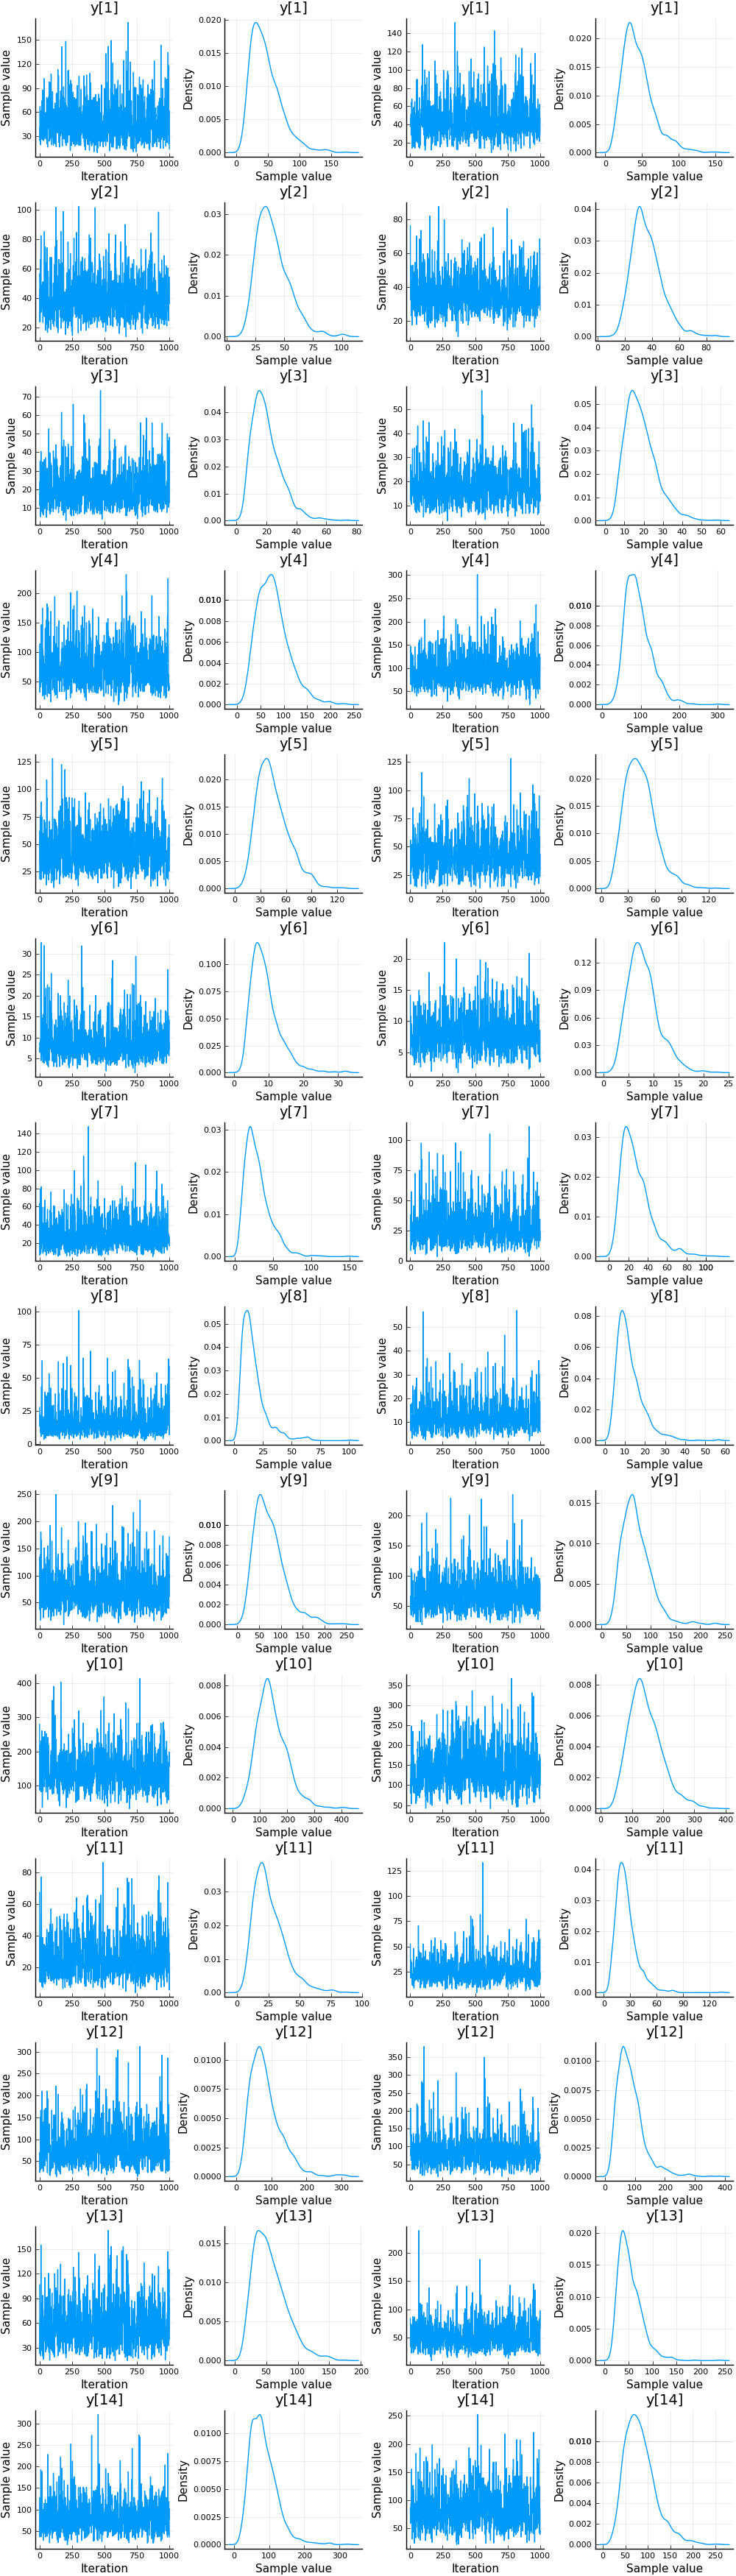

In [57]:
plot(p1, p2, layout = (1, 2))

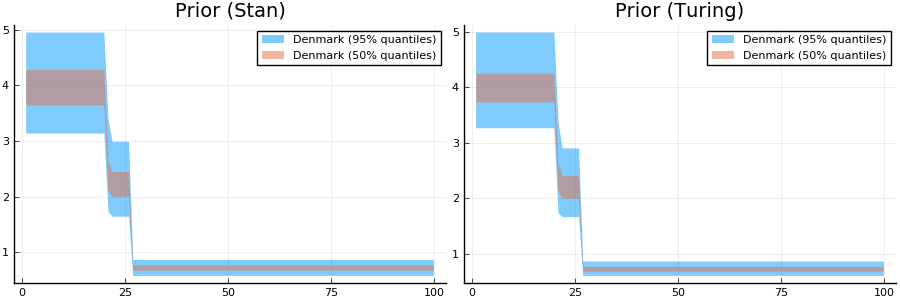

In [58]:
country_idx = 1

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

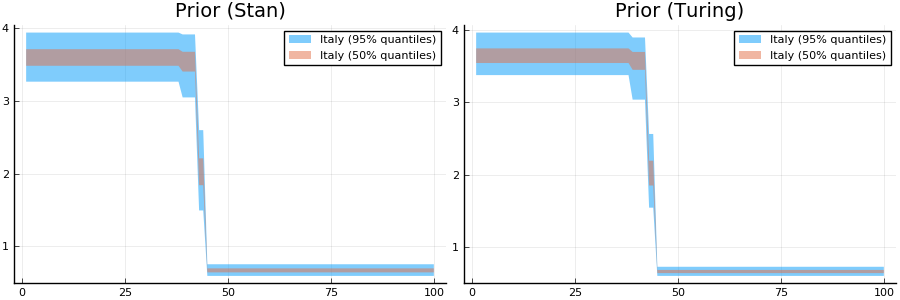

In [59]:
country_idx = 2

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

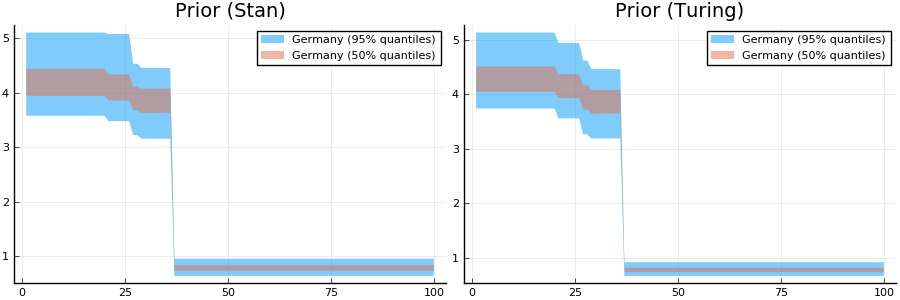

In [60]:
country_idx = 3

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

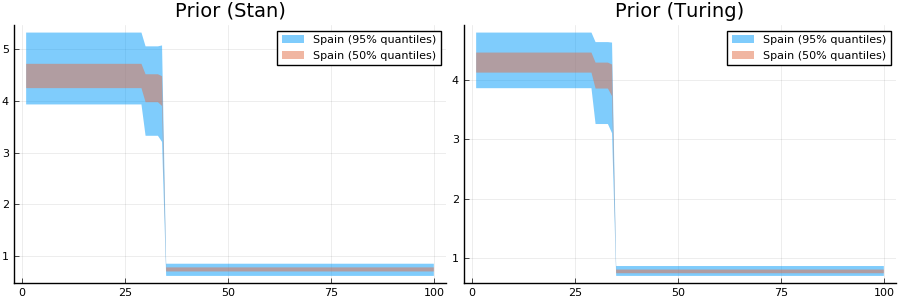

In [61]:
country_idx = 4

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

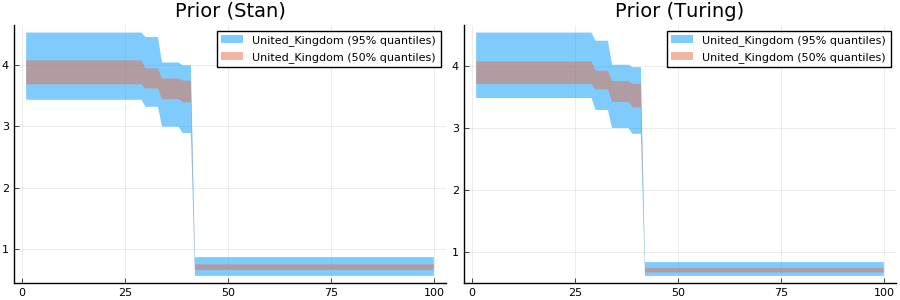

In [62]:
country_idx = 5

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

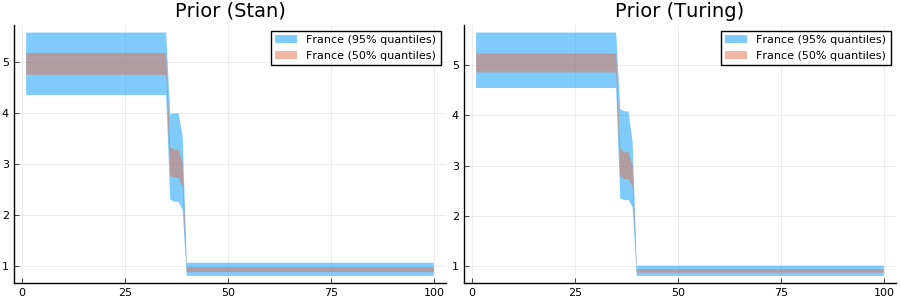

In [63]:
country_idx = 6

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

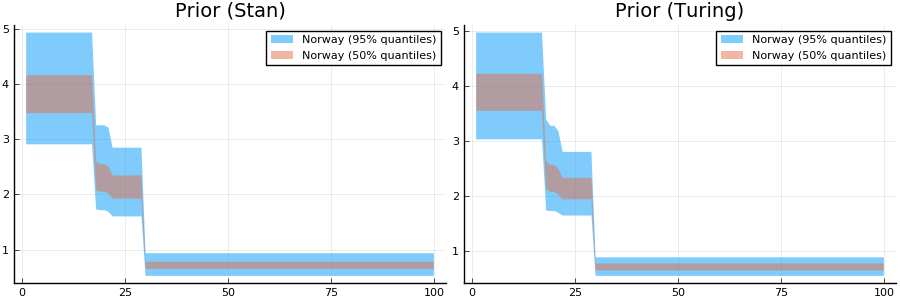

In [64]:
country_idx = 7

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

## Comparing the generated quantities

In [65]:
predictions_stan = [transpose(la["prediction"][:, :, m]) for m = 1:data.num_countries]
expected_deaths_stan = [transpose(la["E_deaths"][:, :, m]) for m = 1:data.num_countries]
Rₜ_stan = [transpose(la["Rt"][:, :, m]) for m = 1:data.num_countries];

function country_stan_prediction_plot(country_idx)
    e_deaths_country = expected_deaths_stan[country_idx]
    Rₜ_country = Rₜ_stan[country_idx]
    predictions_country = predictions_stan[country_idx]

    return country_prediction_plot(country_idx, e_deaths_country, Rₜ_country, predictions_country)
end

country_stan_prediction_plot (generic function with 1 method)

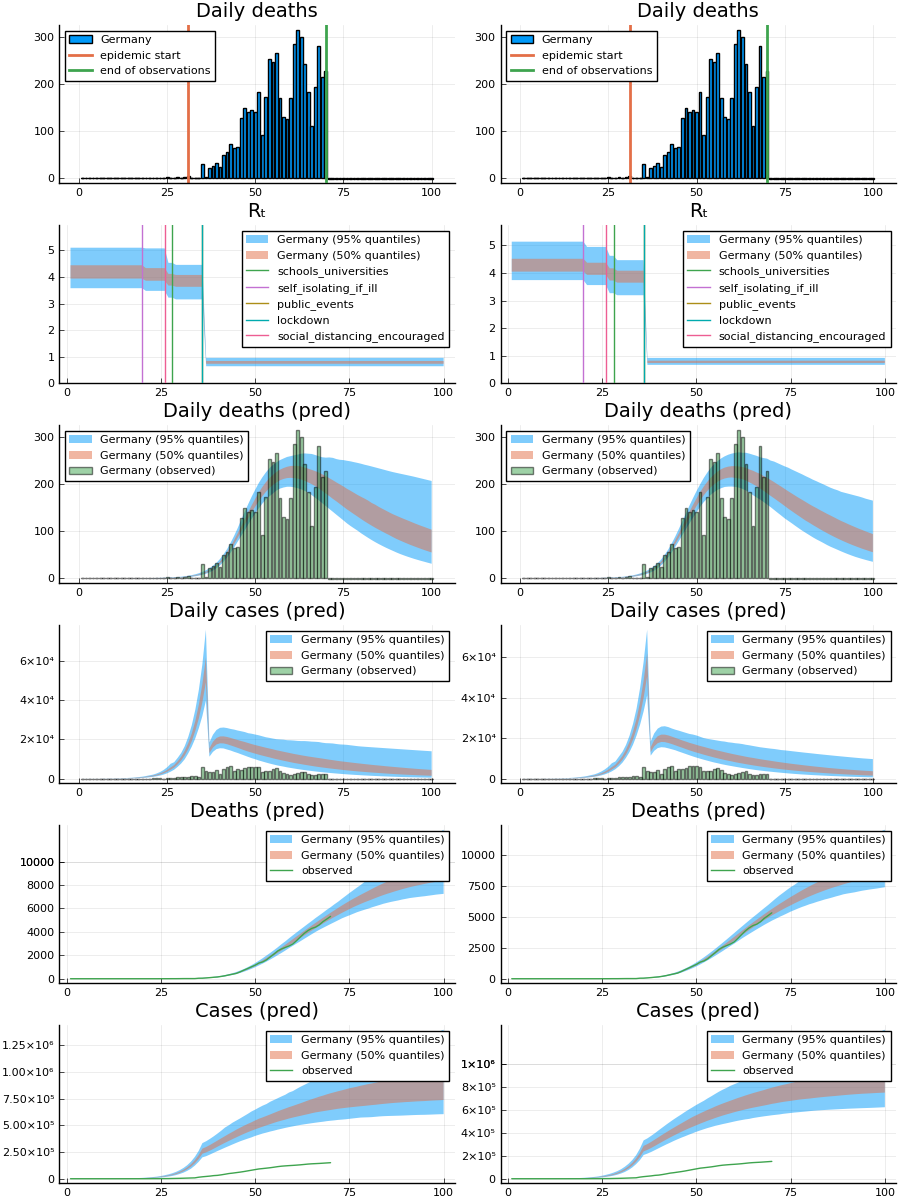

In [66]:
plot(country_stan_prediction_plot(3), country_posterior_prediction_plot(3), layout=(1, 2))

## Sampling from the prior (NOTE: Stan model is outdated!)

This approach to sampling from the prior using Stan comes from https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#step-four-build-a-model

In [59]:
stan_prior_model_str = """
data {
  int <lower=1> M; // number of countries
  int <lower=1> N0; // number of days for which to impute infections
  int<lower=1> N[M]; // days of observed data for country m. each entry must be <= N2
  int<lower=1> N2; // days of observed data + # of days to forecast
  int cases[N2,M]; // reported cases
  int deaths[N2, M]; // reported deaths -- the rows with i > N contain -1 and should be ignored
  matrix[N2, M] f; // h * s
  matrix[N2, M] covariate1;
  matrix[N2, M] covariate2;
  matrix[N2, M] covariate3;
  matrix[N2, M] covariate4;
  matrix[N2, M] covariate5;
  matrix[N2, M] covariate6;
  int EpidemicStart[M];
  real pop[M];
  real SI[N2]; // fixed pre-calculated SI using emprical data from Neil
}

generated quantities {
  real<lower=0> mu[M]; // intercept for Rt
  real<lower=0> alpha_hier[6]; // sudo parameter for the hier term for alpha
  real<lower=0> kappa;
  real<lower=0> y[M];
  real<lower=0> phi;
  real<lower=0> tau;
  real<lower=0> ifr_noise[M];

  real alpha[6];
  matrix[N2, M] prediction = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths  = rep_matrix(0,N2,M);
  matrix[N2, M] Rt = rep_matrix(0,N2,M);
  matrix[N2, M] Rt_adj = Rt;

  matrix[N2, M] prediction0 = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths0  = rep_matrix(0,N2,M);

  tau = exponential_rng(0.03);
  for (m in 1:M){
    y[m] = exponential_rng(1/tau);
  }
  phi = fabs(normal_rng(0,5));
  kappa = fabs(normal_rng(0,0.5));
  for (m in 1:M) mu[m] = fabs(normal_rng(3.28, kappa)); // citation: https://academic.oup.com/jtm/article/27/2/taaa021/5735319
  for (i in 1:6) alpha_hier[i] = gamma_rng(.1667,1);
  for (m in 1:M) ifr_noise[m] = fabs(normal_rng(1,0.1));
    
  {
    matrix[N2,M] cumm_sum = rep_matrix(0,N2,M);
    for(i in 1:6){
      alpha[i] = alpha_hier[i] - ( log(1.05) / 6.0 );
    }
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum[i,m] = cumm_sum[i-1,m] + y[m]; 
      }
      prediction[1:N0,m] = rep_vector(y[m],N0); // learn the number of cases in the first N0 days
        
      Rt[,m] = mu[m] * exp( covariate1[,m] * (-alpha[1]) + covariate2[,m] * (-alpha[2]) +
                            covariate3[,m] * (-alpha[3]) + covariate4[,m] * (-alpha[4]) + covariate5[,m] * (-alpha[5]) + 
                            covariate6[,m] * (-alpha[6]) );
      Rt_adj[1:N0,m] = Rt[1:N0,m];
      for (i in (N0+1):N2) {
        real convolution=0;
        for(j in 1:(i-1)) {
          convolution += prediction[j, m] * SI[i-j];
        }
        cumm_sum[i,m] = cumm_sum[i-1,m] + prediction[i-1,m];
        Rt_adj[i,m] = ((pop[m]-cumm_sum[i,m]) / pop[m]) * Rt[i,m];
        prediction[i, m] = Rt_adj[i,m] * convolution;
      }
        
      E_deaths[1, m]= 1e-15 * prediction[1,m];
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths[i,m] += prediction[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }

  {
    matrix[N2,M] cumm_sum0 = rep_matrix(0,N2,M);
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + y[m]; 
      }
      prediction0[1:N0,m] = rep_vector(y[m],N0); 
      for (i in (N0+1):N2) {
        real convolution0 = 0;
        for(j in 1:(i-1)) {
          convolution0 += prediction0[j, m] * SI[i-j]; 
        }
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + prediction0[i-1,m];
        prediction0[i, m] =  ((pop[m]-cumm_sum0[i,m]) / pop[m]) * mu[m] * convolution0;
      }
        
      E_deaths0[1, m] = uniform_rng(1e-16, 1e-15);
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths0[i,m] += prediction0[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }
}

""";

In [60]:
sm_prior = pystan.StanModel(model_code=stan_prior_model_str)

fit_stan_prior(n_iters=2_000) = sm_prior.sampling(
    # I believe `refresh` ensures that we 
    data=d, iter=n_iters, chains=1, warmup=0, algorithm="Fixed_param", refresh=n_iters
)

f_prior = fit_stan_prior(10000)

Iteration:    1 / 10000 [  0%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               74.8134 seconds (Sampling)
               74.8134 seconds (Total)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f81a2e31bcfa3936009652c0191c457 NOW.


PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_8f81a2e31bcfa3936009652c0191c457.
1 chains, each with iter=10000; warmup=0; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                   mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
mu[1]              3.28  5.4e-3   0.51    2.16     3.1    3.28   3.46   4.38   9047    1.0
mu[2]              3.27  5.1e-3   0.51    2.13    3.09    3.28   3.46   4.36  10149    1.0
mu[3]              3.27  5.0e-3   0.51    2.15    3.09    3.28   3.46   4.38  10151    1.0
mu[4]              3.27  5.2e-3   0.51    2.11     3.1    3.28   3.46   4.38   9589    1.0
mu[5]              3.29  4.9e-3    0.5     2.2     3.1    3.28   3.47    4.4  10473    1.0
mu[6]              3.27  5.1e-3    0.5    2.15    3.09    3.28   3.46   4.36   9832    1.0
mu[7]              3.28  5.2e-3   0.51     2.2    3.09    3.28   3.46   4.43   9448    1.0
mu[8]              3.28  5.0e-3   

In [61]:
la_prior = f_prior.extract(permuted=true)

Dict{Any,Any} with 15 entries:
  "E_deaths"    => [1.93159e-14 2.94219e-7 … 1008.33 1043.77; 8.37835e-14 1.295…
  "ifr_noise"   => [0.932645 1.06777 … 0.941498 1.01813; 0.946476 0.991688 … 1.…
  "tau"         => [16.2041, 42.9077, 153.11, 23.2202, 74.2451, 25.5254, 3.2966…
  "Rt_adj"      => [3.78084 3.78084 … 0.585558 0.560035; 3.41405 3.41405 … 0.55…
  "mu"          => [3.78084 4.57955 … 4.41693 3.11725; 3.41405 3.09974 … 3.4714…
  "kappa"       => [1.03965, 0.341771, 0.026509, 0.691418, 0.0179919, 0.503431,…
  "phi"         => [3.65083, 0.920548, 1.78998, 0.637701, 2.73622, 6.42802, 2.1…
  "prediction"  => [19.3159 19.3159 … 69786.9 63050.7; 83.7835 83.7835 … 46193.…
  "alpha_hier"  => [3.49166e-5 0.0761509 … 0.196094 0.118679; 0.000500638 9.942…
  "Rt"          => [3.78084 3.78084 … 2.1183 2.1183; 3.41405 3.41405 … 1.97992 …
  "y"           => [19.3159 2.39715 … 21.9235 4.43297; 83.7835 19.0364 … 40.310…
  "alpha"       => [-0.00809678 0.0680193 … 0.187963 0.110548; -0.00763106 -0.

In [112]:
mean_Rₜ_stan = mean(la_prior["Rt"]; dims = 1)[1, :, :]

90×14 Array{Float64,2}:
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196  …  3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 3.28131  3.27195  3.26944  3.27196     3.27739  3.28623  3.28146  3.28396
 

In [113]:
res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

In [114]:
mean_Rₜ_turing = mean([hcat(Rₜ_prior[i]...) for i = 1:length(Rₜ_prior)])

90×14 Array{Float64,2}:
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602  …  3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 3.28235  3.28181  3.27853  3.28602     3.28707  3.27402  3.27614  3.27664
 

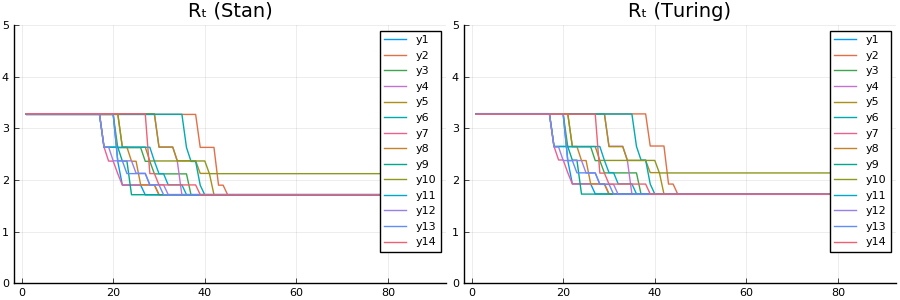

In [115]:
p1 = plot(mean_Rₜ_stan)
title!("Rₜ (Stan)")

p2 = plot(mean_Rₜ_turing)
title!("Rₜ (Turing)")

plot(p1, p2, size = (900, 300))
ylims!(0, 5)

In [116]:
stan_prior_chain = Chains(la_prior["y"], ["y[$i]" for i = 1:size(la_prior["y"], 2)])

Object of type Chains, with data of type 10000×14×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean      std  naive_se    mcse         ess   r_hat
  ──────────  ───────  ───────  ────────  ──────  ──────────  ──────
        y[1]  34.1684  60.3428    0.6034  0.5971  10231.2254  1.0000
        y[2]  33.3878  57.1536    0.5715  0.5940  10345.6889  1.0002
        y[3]  33.6822  58.6989    0.5870  0.6520   8930.0235  1.0001
        y[4]  33.2693  57.9423    0.5794  0.5481   9930.0544  0.9999
        y[5]  33.9689  61.9302    0.6193  0.6284   9507.2542  1.0001
        y[6]  34.2339  60.0826    0.6008  0.5547  10032.3907  1.0000
        y[7]  35.3289  65.2461    0.6525  0.6251   9835.0885  0.9999
        y[8]  34.3868  60.0357    0.6004  0.5239

In [117]:
p1 = plot(stan_prior_chain[:y]);

In [118]:
p2 = plot(chain_prior[:y]);

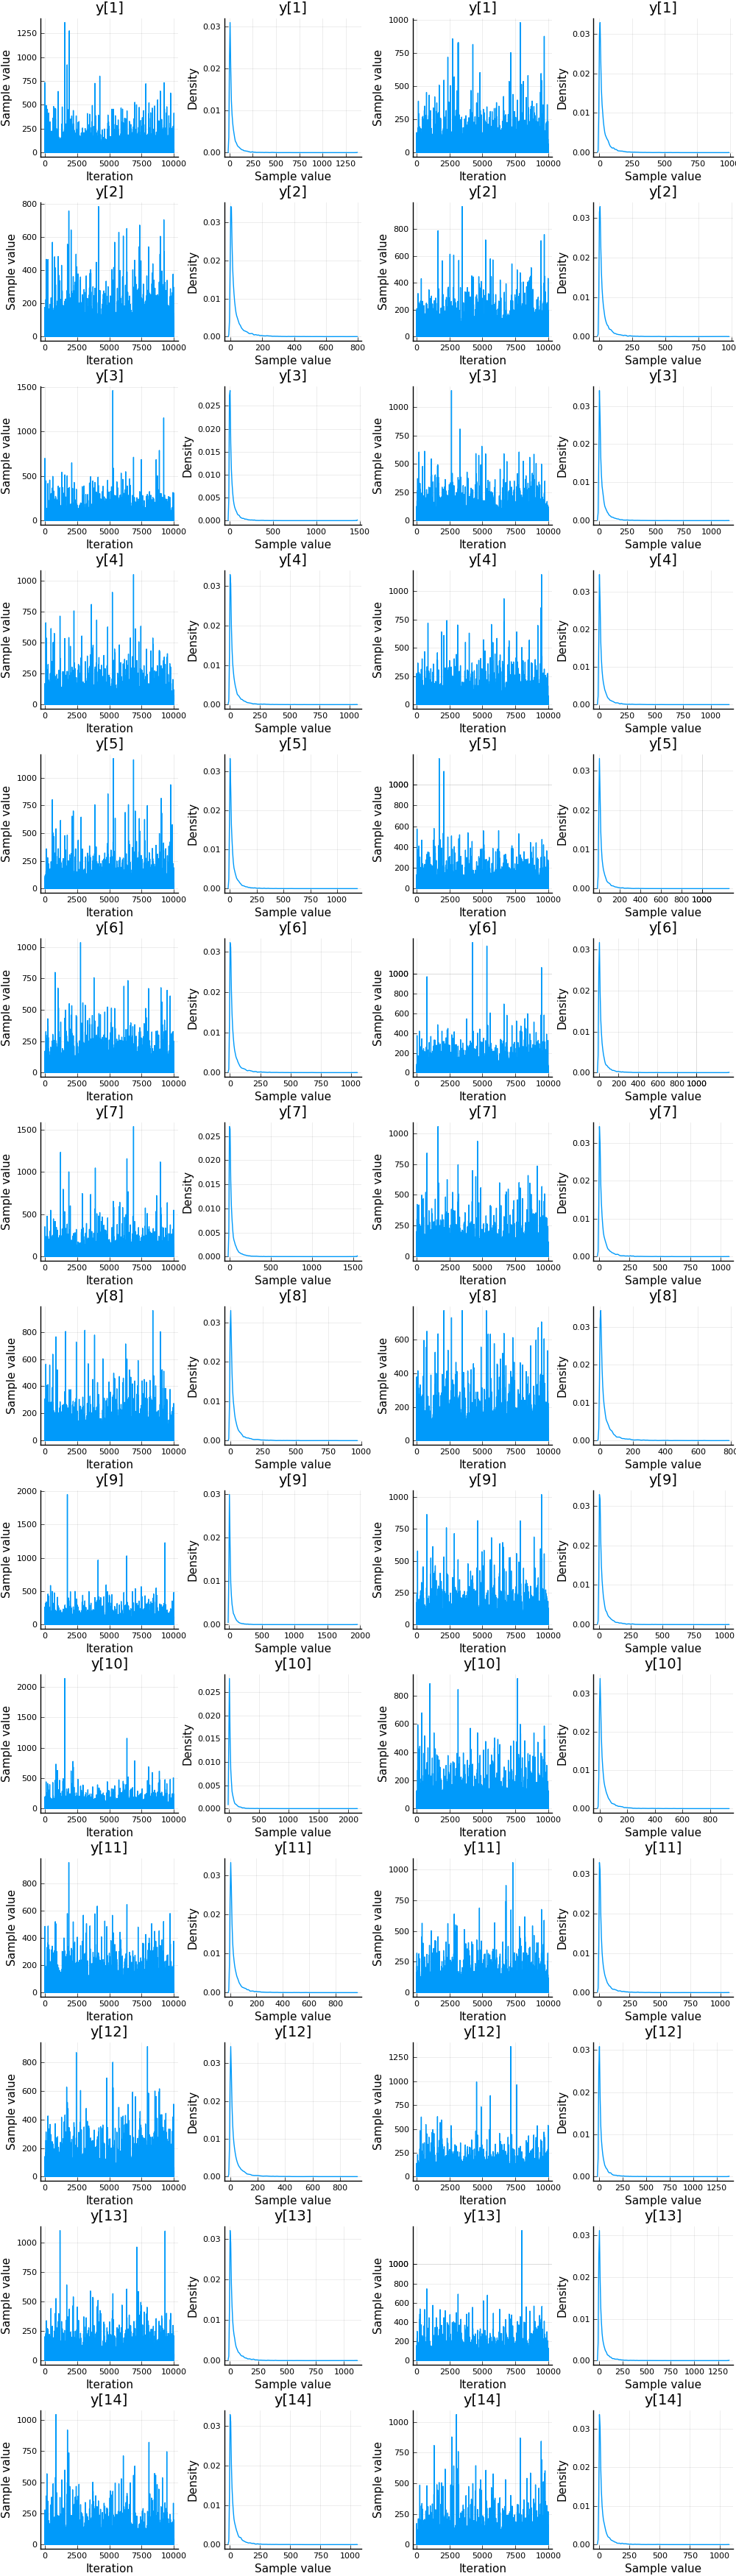

In [119]:
plot(p1, p2, layout = (1, 2))

In [120]:
country_idx = 7

7

In [121]:
hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)'

10000×90 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.29968  3.29968  3.29968  3.29968  3.29968  …  2.33792   2.33792   2.33792 
 3.61216  3.61216  3.61216  3.61216  3.61216     3.42996   3.42996   3.42996 
 3.33432  3.33432  3.33432  3.33432  3.33432     1.94388   1.94388   1.94388 
 3.45655  3.45655  3.45655  3.45655  3.45655     2.3189    2.3189    2.3189  
 3.27459  3.27459  3.27459  3.27459  3.27459     0.774836  0.774836  0.774836
 3.33379  3.33379  3.33379  3.33379  3.33379  …  1.17719   1.17719   1.17719 
 3.72393  3.72393  3.72393  3.72393  3.72393     3.38807   3.38807   3.38807 
 2.72857  2.72857  2.72857  2.72857  2.72857     0.178619  0.178619  0.178619
 3.04221  3.04221  3.04221  3.04221  3.04221     1.17235   1.17235   1.17235 
 3.79909  3.79909  3.79909  3.79909  3.79909     1.12903   1.12903   1.12903 
 2.88363  2.88363  2.88363  2.88363  2.88363  …  1.28103   1.28103   1.28103 
 3.24855  3.24855  3.24855  3.24855  3.24855     2.93994   2.93994   2.93994 
 3.208

In [122]:
la_prior["Rt"][:, :, country_idx]

10000×90 Array{Float64,2}:
 3.534    3.534    3.534    3.534    …  1.98001    1.98001    1.98001  
 2.73274  2.73274  2.73274  2.73274     1.58481    1.58481    1.58481  
 3.28135  3.28135  3.28135  3.28135     2.90651    2.90651    2.90651  
 3.89443  3.89443  3.89443  3.89443     1.93188    1.93188    1.93188  
 3.28516  3.28516  3.28516  3.28516     2.3406     2.3406     2.3406   
 2.91645  2.91645  2.91645  2.91645  …  1.37546    1.37546    1.37546  
 3.27458  3.27458  3.27458  3.27458     3.22629    3.22629    3.22629  
 3.08715  3.08715  3.08715  3.08715     0.351149   0.351149   0.351149 
 3.87312  3.87312  3.87312  3.87312     3.37153    3.37153    3.37153  
 2.45081  2.45081  2.45081  2.45081     2.53       2.53       2.53     
 3.04146  3.04146  3.04146  3.04146  …  0.714928   0.714928   0.714928 
 4.29187  4.29187  4.29187  4.29187     0.0825957  0.0825957  0.0825957
 3.41862  3.41862  3.41862  3.41862     0.985535   0.985535   0.985535 
 ⋮                                   

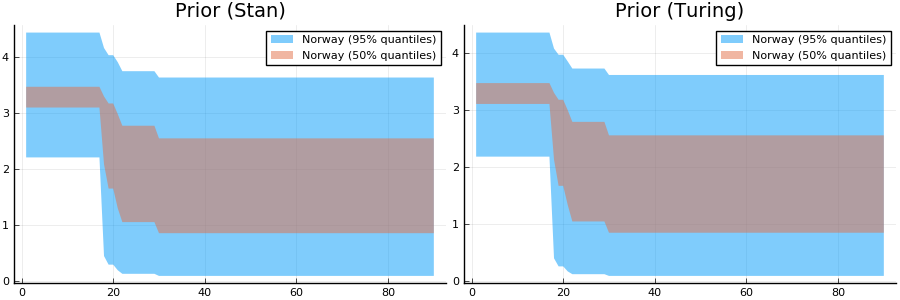

In [123]:
vals = la_prior["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

In [124]:
stan_chain_alpha_hier = Chains(la_prior["alpha_hier"], ["α_hier[$i]" for i = 1:6])

Object of type Chains, with data of type 10000×6×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse         ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ──────────  ──────
   α_hier[1]  0.1673  0.4020    0.0040  0.0037   9534.1084  1.0003
   α_hier[2]  0.1692  0.4160    0.0042  0.0044  10113.1276  1.0001
   α_hier[3]  0.1687  0.4110    0.0041  0.0039  10211.8029  1.0000
   α_hier[4]  0.1708  0.4190    0.0042  0.0044  10161.5811  1.0000
   α_hier[5]  0.1629  0.4172    0.0042  0.0048  10077.0580  0.9999
   α_hier[6]  0.1660  0.4140    0.0041  0.0042   9751.3710  1.0000

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
   α_hier[1]  0.0000  0.0002  0.0096  0.

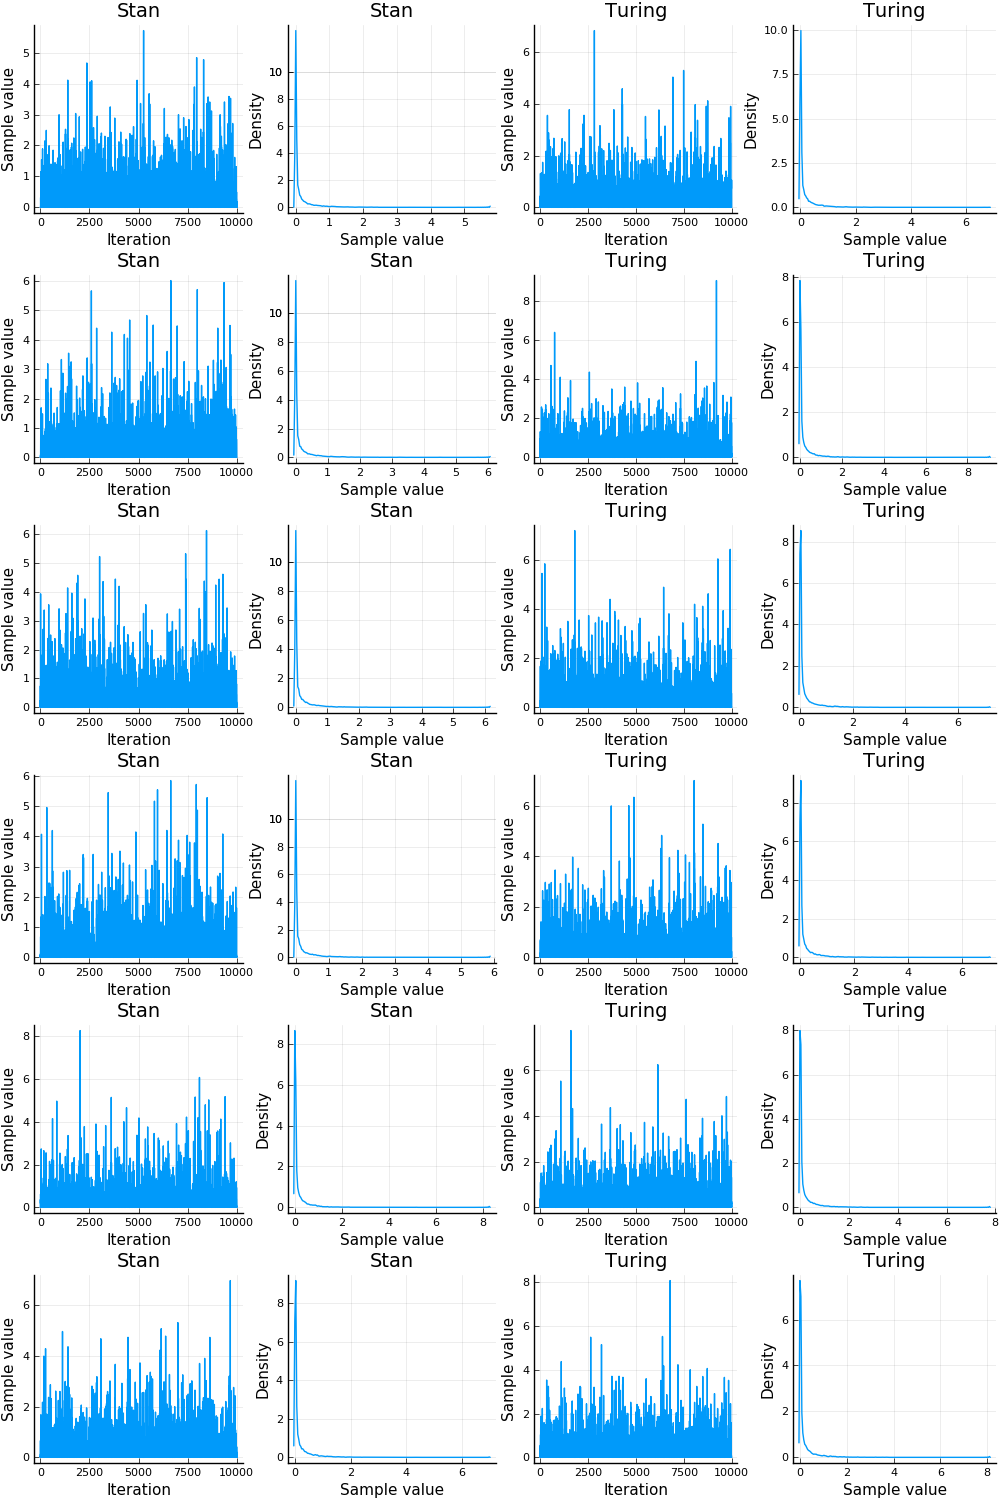

In [125]:
p1 = plot(stan_chain_alpha_hier[:α_hier])
title!("Stan")
p2 = plot(chain_prior[:α_hier])
title!("Turing")

plot(p1, p2, layout = (1, 2))

# Debugging stufff

## Type-stability

In [27]:
varinfo = Turing.VarInfo(m);
@code_warntype m.f(m, varinfo, Turing.DynamicPPL.SampleFromPrior(), Turing.DynamicPPL.DefaultContext())

Variables
  #self#::Core.Compiler.Const(##evaluator#804, false)
  _model::DynamicPPL.Model{var"###evaluator#804",(:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :covariates, :epidemic_start, :population, :serial_intervals, :predict, :TV),Tuple{Int64,Int64,Array{Int64,1},Int64,Array{SubArray{Int64,1,Array{Int64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1},Array{SubArray{Int64,1,Array{Int64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1},Array{SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1},Array{Array{Float64,2},1},Array{Int64,1},Array{Int64,1},Array{Float64,1},Bool,Type{Array{Float64,1}}},(),DynamicPPL.ModelGen{var"###generator#805",(:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :covariates, :epidemic_start, :population, :serial_intervals, :predict, :TV),(:predict, :TV),Tuple{Bool,Type{Array{Float64,1}}}}}
  _varinfo::DynamicPPL.VarInfo{NamedTuple{(:

1 ──        Core.NewvarNode(:(vn#762))
│           Core.NewvarNode(:(inds#763))
│           Core.NewvarNode(:(out#761))
│           Core.NewvarNode(:(τ))
│           Core.NewvarNode(:(tmpright#764))
│           Core.NewvarNode(:(vn#767))
│           Core.NewvarNode(:(inds#768))
│           Core.NewvarNode(:(out#766))
│           Core.NewvarNode(:(y))
│           Core.NewvarNode(:(tmpright#769))
│           Core.NewvarNode(:(vn#772))
│           Core.NewvarNode(:(inds#773))
│           Core.NewvarNode(:(out#771))
│           Core.NewvarNode(:(ϕ))
│           Core.NewvarNode(:(tmpright#774))
│           Core.NewvarNode(:(vn#777))
│           Core.NewvarNode(:(inds#778))
│           Core.NewvarNode(:(out#776))
│           Core.NewvarNode(:(κ))
│           Core.NewvarNode(:(tmpright#779))
│           Core.NewvarNode(:(vn#782))
│           Core.NewvarNode(:(inds#783))
│           Core.NewvarNode(:(out#781))
│           Core.NewvarNode(:(μ₀))
│           Core.NewvarNode(:(μ))
│           Cor

│           (TV = (DynamicPPL.matchingvalue)(_sampler, _varinfo, %81))
│    %83  = Base.getindex(covariates, 1)::Array{Float64,2}
│           (num_covariates = Main.size(%83, 2))
│    %85  = (1 / 0.03)::Core.Compiler.Const(33.333333333333336, false)
│           (tmpright#759 = Main.Exponential(%85))
│    %87  = tmpright#759::Core.Compiler.Const(Exponential{Float64}(θ=33.333333333333336), false)::Core.Compiler.Const(Exponential{Float64}(θ=33.333333333333336), false)
│           (@_64 = Core.TypeVar(Symbol("#s898"), Distribution))
│    %89  = @_64::Core.Compiler.PartialTypeVar(#s898<:Distribution, true, true)::Core.Compiler.PartialTypeVar(#s898<:Distribution, true, true)
│    %90  = Core.apply_type(Main.AbstractVector, @_64::Core.Compiler.PartialTypeVar(#s898<:Distribution, true, true))::Type{AbstractArray{#s898<:Distribution,1}}
│    %91  = Core.UnionAll(%89, %90)::Type{AbstractArray{#s898,1} where #s898<:Distribution}
│    %92  = Core.apply_type(Main.Union, Distribution, %91)::Type{Uni

│    %182 = Main.Gamma(0.1667, 1)::Core.Compiler.Const(Gamma{Float64}(α=0.1667, θ=1.0), false)
│           (tmpright#784 = Main.filldist(%182, num_covariates))
│    %184 = tmpright#784::Core.Compiler.PartialStruct(Product{Continuous,Gamma{Float64},FillArrays.Fill{Gamma{Float64},1,Tuple{Base.OneTo{Int64}}}}, Any[Core.Compiler.PartialStruct(FillArrays.Fill{Gamma{Float64},1,Tuple{Base.OneTo{Int64}}}, Any[Core.Compiler.Const(Gamma{Float64}(α=0.1667, θ=1.0), false), Tuple{Base.OneTo{Int64}}])])::Core.Compiler.PartialStruct(Product{Continuous,Gamma{Float64},FillArrays.Fill{Gamma{Float64},1,Tuple{Base.OneTo{Int64}}}}, Any[Core.Compiler.PartialStruct(FillArrays.Fill{Gamma{Float64},1,Tuple{Base.OneTo{Int64}}}, Any[Core.Compiler.Const(Gamma{Float64}(α=0.1667, θ=1.0), false), Tuple{Base.OneTo{Int64}}])])
│           (@_69 = Core.TypeVar(Symbol("#s893"), Distribution))
│    %186 = @_69::Core.Compiler.PartialTypeVar(#s893<:Distribution, true, true)::Core.Compiler.PartialTypeVar(#s893<:Distribution,

26 ┄        (@_75 = Base._array_for(TV::Core.Compiler.Const(Array{Float64,1}, false), %270, %271))
│    %278 = Base.LinearIndices(@_75)::LinearIndices{1,Tuple{Base.OneTo{Int64}}}
│           (@_76 = Base.first(%278))
│    %280 = %270::Core.Compiler.PartialStruct(UnitRange{Int64}, Any[Core.Compiler.Const(1, false), Int64])
│           (@_77 = Base.iterate(%280))
│    %282 = (@_77 === nothing)::Bool
│    %283 = Base.not_int(%282)::Bool
└───        goto #31 if not %283
27 ┄ %285 = @_77::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│           (m@_78 = Core.getfield(%285, 1))
│    %287 = Core.getfield(%285, 2)::Int64
│    %288 = Base.getindex(last_time_steps, m@_78)::Int64
│    %289 = (TV::Core.Compiler.Const(Array{Float64,1}, false))(Main.undef, %288)::Array{Float64,1}
│           $(Expr(:inbounds, true))
└───        goto #29 if not %272
28 ─        Core.Compiler.Const(:(Base.push!(@_75, %289)), false)
└───        Core.Compiler.Const(:(goto %295), false)
29 ┄        Base.setindex!(@_75, %289, @

│    %415 = xs::Array{Float64,2}
│    %416 = -α::Array{Float64,1}
│    %417 = (%415 * %416)::Array{Float64,1}
│    %418 = Base.broadcasted(Main.exp, %417)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(exp),Tuple{Array{Float64,1}}}
│    %419 = Base.materialize(%418)::Array{Float64,1}
│    %420 = (%414 * %419)::Array{Float64,1}
│    %421 = Base.broadcasted(Base.identity, %420)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(identity),Tuple{Array{Float64,1}}}
│           Base.materialize!(%413, %421)
│    %423 = (num_impute + 1)::Int64
│    %424 = (%423:last_time_step)::UnitRange{Int64}
│           (@_95 = Base.iterate(%424))
│    %426 = (@_95 === nothing)::Bool
│    %427 = Base.not_int(%426)::Bool
└───        goto #49 if not %427
47 ┄ %429 = @_95::Tuple{Int64,Int64}::Tuple{Int64,Int64}
│           (t@_98 = Core.getfield(%429, 1))
│    %431 = Core.getfield(%429, 2)::Int64
│    %432 = cases_pred_m::Array{Float64,1}
│    %433 =

└───        goto #57 if not %538
56 ─        goto #58
57 ─ %541 = Main.ArgumentError("Right-hand side of a ~ must be subtype of Distribution or a vector of Distributions.")::ArgumentError
└───        Main.throw(%541)
58 ┄ %543 = Core.tuple(m@_110)::Tuple{Int64}
│    %544 = Core.tuple(ts)::Tuple{UnitRange{Int64}}
│    %545 = Core.tuple(%543, %544)::Tuple{Tuple{Int64},Tuple{UnitRange{Int64}}}
│           (vn#797 = (DynamicPPL.VarName)(:deaths, %545))
│    %547 = Core.tuple(m@_110)::Tuple{Int64}
│    %548 = Core.tuple(ts)::Tuple{UnitRange{Int64}}
│           (inds#798 = Core.tuple(%547, %548))
│    %550 = Core.tuple(m@_110)::Tuple{Int64}
│    %551 = Core.tuple(ts)::Tuple{UnitRange{Int64}}
│    %552 = Core.tuple(%550, %551)::Tuple{Tuple{Int64},Tuple{UnitRange{Int64}}}
│           (vn#802 = (DynamicPPL.VarName)(:deaths, %552))
│    %554 = (DynamicPPL.inargnames)(vn#802, _model)::Any
│    %555 = !%554::Union{Missing, Bool, Base.var"#58#59"{_A} where _A}
└───        goto #60 if not %555
59 ─ 